<a href="https://colab.research.google.com/github/subikkshas/PREPARE-ALL/blob/main/model_comp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 9.1 MB/s eta 0:00:00


In [ ]:
### function to remove features
import pandas as pd
def remove_columns(df, feature_set='normal'):

    # Define base leakage columns to always remove
    base_leakage_cols = [
        "Sl No",
        "UPN_AI_dataset",
        # All Date columns
        "Date of Birth", "Date of Diagnosis", "Date of Remission_EOI",
        "Date of Completion of treatment", "Date of Relapse",
        "Date of Death ", "Date of Treatment abandonment/ Disease progresssion/Off protocol",
        "Date of Last FU",
        # Relapse & outcome details
        "Time-point of Relapse ", "Type of relapse", "Site of Relapse ",
        "Death", "Treatment death phase",
        "Treatment abandonment/Disease progresssion/Off protocol",
        "Current status at Last Follow up ", "Remission status _EOI"
    ]

    # Additional columns to remove for minimal feature set
    minimal_cols = [
        "Previous Treatment", "NCI Risk", "Lineage", "Bulky Disease",
        "CNS Disease", "Detail cytogenetics", "Provisional risk",
    ]

    # Combine columns based on feature_set parameter
    if feature_set == 'minimal':
        cols_to_remove = base_leakage_cols + minimal_cols
    else:  # 'normal' or any other value
        cols_to_remove = base_leakage_cols

    # Remove only columns that exist in the dataframe
    existing_cols_to_remove = [c for c in cols_to_remove if c in df.columns]
    df_clean = df.drop(columns=existing_cols_to_remove)

    return df_clean



### function to clean string columns
def clean_string_columns(df, columns_to_clean):
  existing_cols_to_clean = [col for col in columns_to_clean if col in df.columns]

  for col in existing_cols_to_clean:
      df[col] = df[col].astype("string").str.strip().str.lower()

  return df



### function to remove entry which are not in remission
def filter_remission_status(df):
  if 'Remission status _EOI' in df.columns:
    # Filter out 'not in remission' records (case-insensitive) but keep <NA>
    df_filter = df[df['Remission status _EOI'].astype(str).str.lower() != 'not in remission'].copy()
    print(f"Original dataset shape: {df.shape}")
    print(f"Filtered dataset shape: {df_filter.shape}")
    print(f"Number of rows removed: {df.shape[0] - df_filter.shape[0]}")
    return df_filter

  else:
    print("Column 'Remission status _EOI' not found in the DataFrame.")
    return df



### funtion to split the data
from sklearn.model_selection import train_test_split
def split_data(df, target_col="Relapsed", test_size=0.20, random_state=42, stratify=True):

    # Check if target column exists
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in dataframe")

    # Prepare features and target
    X = df.drop(columns=[target_col])
    y = df[target_col].astype("category").cat.codes  # Convert Yes/No to 0/1

    # Split data
    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )

    # Print summary
    print("Data split summary:")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"Training set class distribution: {dict(zip(y_train.value_counts().index, y_train.value_counts().values))}")
    print(f"Test set class distribution: {dict(zip(y_test.value_counts().index, y_test.value_counts().values))}")

    return X_train, X_test, y_train, y_test



### function to load the data from drive
from google.colab import drive
import pandas as pd
import os

def load_train_test_data(load_path='/content/drive/MyDrive/Final data/'):
    # Mount Google Drive (if not already mounted)
    try:
        drive.mount('/content/drive')
        print("Google Drive mounted successfully.")
    except:
        print("Google Drive already mounted or mounting failed.")

    # Load the data files
    try:
        loaded_X_train = pd.read_csv(os.path.join(load_path, 'X_train_encoded.csv'))
        loaded_y_train = pd.read_csv(os.path.join(load_path, 'y_train_encoded.csv'))
        loaded_X_test = pd.read_csv(os.path.join(load_path, 'X_test_encoded.csv'))
        loaded_y_test = pd.read_csv(os.path.join(load_path, 'loaded_y_test.csv'))

        print("Data loaded successfully!")
        print(f"X_train shape: {loaded_X_train.shape}")
        print(f"y_train shape: {loaded_y_train.shape}")
        print(f"X_test shape: {loaded_X_test.shape}")
        print(f"y_test shape: {loaded_y_test.shape}")

        return loaded_X_train, loaded_y_train, loaded_X_test, loaded_y_test

    except FileNotFoundError as e:
        print(f"Error: File not found - {e}")
        return None, None, None, None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None, None



### function for imputation
from sklearn.impute import SimpleImputer
import pandas as pd
from typing import List, Tuple, Dict

def impute_train_test(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    categorical_cols: List[str],
    numeric_cols: List[str],
    numeric_strategy: str = "median",
) -> Tuple[pd.DataFrame, pd.DataFrame, Dict[str, SimpleImputer]]:
    """
    Fit imputers on X_train and transform both X_train and X_test.
    - Categorical: most_frequent
    - Numeric: numeric_strategy (default median)

    Returns:
        X_train_imp, X_test_imp, {'cat': cat_imputer, 'num': num_imputer}
    """
    # Safety: work on copies
    X_train_imp = X_train.copy()
    X_test_imp  = X_test.copy()

    # Filter to existing columns (avoids KeyErrors if lists have extras)
    cat_cols_exist = [c for c in categorical_cols if c in X_train.columns]
    num_cols_exist = [c for c in numeric_cols if c in X_train.columns]

    # Define imputers
    cat_imputer = SimpleImputer(strategy="most_frequent")
    num_imputer = SimpleImputer(strategy=numeric_strategy)

    # --- Fit on TRAIN ---
    if cat_cols_exist:
        X_train_imp[cat_cols_exist] = cat_imputer.fit_transform(X_train_imp[cat_cols_exist])
        # Cast back to object to keep them categorical-like
        for c in cat_cols_exist:
            X_train_imp[c] = X_train_imp[c].astype(object)

    if num_cols_exist:
        X_train_imp[num_cols_exist] = num_imputer.fit_transform(X_train_imp[num_cols_exist])
        # Ensure numeric dtype
        for c in num_cols_exist:
            X_train_imp[c] = pd.to_numeric(X_train_imp[c], errors="coerce")

    # --- Transform TEST with the same fitted imputers ---
    # If test is missing some listed columns, skip them gracefully
    cat_cols_test = [c for c in cat_cols_exist if c in X_test_imp.columns]
    num_cols_test = [c for c in num_cols_exist if c in X_test_imp.columns]

    if cat_cols_test:
        X_test_imp[cat_cols_test] = cat_imputer.transform(X_test_imp[cat_cols_test])
        for c in cat_cols_test:
            X_test_imp[c] = X_test_imp[c].astype(object)

    if num_cols_test:
        X_test_imp[num_cols_test] = num_imputer.transform(X_test_imp[num_cols_test])
        for c in num_cols_test:
            X_test_imp[c] = pd.to_numeric(X_test_imp[c], errors="coerce")

    imputers = {"cat": cat_imputer, "num": num_imputer}
    return X_train_imp, X_test_imp, imputers



### function for encoding
from typing import Dict, List, Tuple, Union
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np

def encode_data_simple(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series = None,
    y_test: pd.Series = None,
    custom_mapping: Dict[str, Dict[str, int]] = None
):
    """
    Simplified version using manual one-hot encoding to avoid sklearn issues.
    """

    # Default mapping
    default_mapping = {
        'Previous Treatment': {'no': 0, 'yes': 1},
        'NCI Risk': {'standard': 0, 'high': 1},
        'Sex': {'male': 0, 'female': 1},
        'Lineage': {'b': 0, 't': 1},
        'Bulky Disease': {'no': 0, 'yes': 1},
        'Prednisolone Response': {'good': 0, 'poor': 1},
        'CNS Disease': {'no': 0, 'yes': 1},
        'Cytogenetic groups ': {'non-high risk': 1, 'not required': 2, 'high risk': 3},
        'Provisional risk': {'standard': 0, 'intermediate': 1, 'high': 2, 't': 3},
        'MRD Status_EOI': {'negative': 1, 'not required': 2, 'positive': 3},
        'Final Risk ': {'standard': 0, 'intermediate': 1, 'high': 2, 't': 3},
        'Relapsed': {'no': 0, 'yes': 1}
    }

    mapping = custom_mapping if custom_mapping is not None else default_mapping
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()
    encoding_info = {'label_mapping': {}}

    # Encode target
    y_train_encoded, y_test_encoded = None, None
    if y_train is not None and y_test is not None:
        if 'Relapsed' in mapping:
            # Create mapping function
            relapsed_map = mapping['Relapsed']
            y_train_encoded = y_train.map(lambda x: relapsed_map.get(str(x).lower(), 0)).astype(int)
            y_test_encoded = y_test.map(lambda x: relapsed_map.get(str(x).lower(), 0)).astype(int)
            encoding_info['label_mapping']['Relapsed'] = mapping['Relapsed']

    # Manual one-hot encoding for 'Detail cytogenetics'
    if 'Detail cytogenetics' in X_train_encoded.columns:
        try:
            # Get all unique categories from training data
            unique_categories = X_train_encoded['Detail cytogenetics'].fillna('unknown').astype(str).unique()

            # Create one-hot encoded columns for training data
            for category in unique_categories:
                col_name = f"cytogenetics_{category}"
                X_train_encoded[col_name] = (X_train_encoded['Detail cytogenetics'].fillna('unknown').astype(str) == category).astype(int)

            # Create same columns for test data (some might be all zeros)
            for category in unique_categories:
                col_name = f"cytogenetics_{category}"
                X_test_encoded[col_name] = (X_test_encoded['Detail cytogenetics'].fillna('unknown').astype(str) == category).astype(int)

            # Drop original column
            X_train_encoded = X_train_encoded.drop('Detail cytogenetics', axis=1)
            X_test_encoded = X_test_encoded.drop('Detail cytogenetics', axis=1)

            encoding_info['onehot_features'] = [f"cytogenetics_{cat}" for cat in unique_categories]

        except Exception as e:
            print(f"Manual one-hot encoding failed: {e}")
            # Fallback to label encoding
            X_train_encoded['Detail cytogenetics'] = X_train_encoded['Detail cytogenetics'].astype('category').cat.codes
            X_test_encoded['Detail cytogenetics'] = X_test_encoded['Detail cytogenetics'].astype('category').cat.codes

    # Apply label encoding to other columns
    for column, value_map in mapping.items():
        if column != 'Relapsed' and column in X_train_encoded.columns:
            # Create a mapping function for this specific column
            def map_value(x, mapping_dict=value_map):
                x_str = str(x).lower().strip() if pd.notna(x) else 'unknown'
                return mapping_dict.get(x_str, 0)  # Default to 0 for unknown values

            X_train_encoded[column] = X_train_encoded[column].apply(map_value)
            if column in X_test_encoded.columns:
                X_test_encoded[column] = X_test_encoded[column].apply(map_value)
            encoding_info['label_mapping'][column] = value_map

    # Handle any remaining categorical columns
    categorical_cols = X_train_encoded.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        if col not in encoding_info['label_mapping']:
            X_train_encoded[col] = X_train_encoded[col].astype('category').cat.codes
            X_test_encoded[col] = X_test_encoded[col].astype('category').cat.codes
            encoding_info['label_mapping'][col] = 'categorical_encoding_auto'

    # Ensure all columns are numeric
    X_train_encoded = X_train_encoded.apply(pd.to_numeric, errors='coerce').fillna(0)
    X_test_encoded = X_test_encoded.apply(pd.to_numeric, errors='coerce').fillna(0)

    print("Encoding completed successfully!")
    print(f"X_train shape after encoding: {X_train_encoded.shape}")
    print(f"X_test shape after encoding: {X_test_encoded.shape}")

    return X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded, encoding_info



import optuna
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (average_precision_score, precision_recall_curve,
                           f1_score, recall_score, precision_score,
                           classification_report, confusion_matrix, roc_auc_score)



### function for optimization + training
from sklearn.metrics import average_precision_score

def tune_with_optuna(X_train, y_train, n_trials=50):

    # Ensure y_train is a Series, not DataFrame
    if isinstance(y_train, pd.DataFrame):
        y_train = y_train.iloc[:, 0]

    pos = sum(y_train == 1)
    neg = sum(y_train == 0)
    scale_pos_weight = neg / pos  # imbalance handling
    # print(scale_pos_weight)

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 800),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 10),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 10),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "scale_pos_weight": scale_pos_weight,
            "random_state": 42,
            "use_label_encoder": False,
            "eval_metric": "logloss",
        }
        model = XGBClassifier(**params)
        model.fit(X_train, y_train)

        # Get predicted probabilities
        y_probs = model.predict_proba(X_train)[:, 1]

        # Optimize AUCPR
        return average_precision_score(y_train, y_probs)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    best_model = XGBClassifier(**study.best_params)
    best_model.fit(X_train, y_train)

    return best_model, study.best_params



### function for threshold tuning
def tune_threshold(model, X_val, y_val, beta = 1):
    y_probs = model.predict_proba(X_val)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_probs)

    #f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
    metric = (1 + beta) * (precisions * recalls) / (precisions + (recalls * beta) + 1e-6)
    best_idx = np.argmax(metric)
    best_threshold = thresholds[best_idx]

    return best_threshold, metric[best_idx]



### function for evaluation
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)

def evaluate_model(model, X_test, y_test, threshold=0.5):
    # Probabilities
    y_probs = model.predict_proba(X_test)[:, 1]

    # Apply threshold
    y_pred = (y_probs >= threshold).astype(int)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_probs)
    cm = confusion_matrix(y_test, y_pred)

    # Print neatly
    print("=== Evaluation Metrics (Summary) ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC AUC  : {auc:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    return



### function for Precision - Recall curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, roc_auc_score

def compare_thresholds(model, X_test, y_test, thresholds=[0.5, 0.55]):
    y_probs = model.predict_proba(X_test)[:, 1]
    precisions, recalls, thresh = precision_recall_curve(y_test, y_probs)

    # Plot PR curve
    plt.figure(figsize=(8,6))
    plt.plot(recalls, precisions, label="PR Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve with Threshold Markers")

    # Mark chosen thresholds
    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        plt.scatter(rec, prec, marker="o", label=f"Threshold={t}")

    plt.legend()
    plt.show()

    # Print metrics comparison
    results = []
    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        results.append({
            "Threshold": t,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "ROC AUC": roc_auc_score(y_test, y_probs)
        })
    return pd.DataFrame(results)



### function for feature imp
import matplotlib.pyplot as plt
import shap
import xgboost as xgb
import pandas as pd

# === Feature Importance (Top 10) ===
def plot_feature_importance(model, feature_names, top_n=10):
    # Get feature importance from trained XGBoost model
    importance = model.get_booster().get_score(importance_type='gain')
    importance_df = pd.DataFrame({
        'feature': list(importance.keys()),
        'importance': list(importance.values())
    }).sort_values(by='importance', ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.barh(importance_df['feature'][::-1], importance_df['importance'][::-1])
    plt.xlabel("Gain Importance")
    plt.title(f"Top {top_n} Features (XGBoost Gain Importance)")
    plt.show()

# Example usage:
# plot_feature_importance(best_model, X_train_encoded.columns)



### function for SHAP
def plot_shap_summary(model, X_train, sample_size=500):
    # Take a sample to speed up SHAP
    if X_train.shape[0] > sample_size:
        X_sample = X_train.sample(sample_size, random_state=42)
    else:
        X_sample = X_train

    # Use TreeExplainer for XGBoost
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)

    # Summary plot (feature importance with SHAP values)
    shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=10)
    shap.summary_plot(shap_values, X_sample)  # beeswarm plot


# Example usage:
# plot_shap_summary(best_model, X_train_encoded)



---



In [ ]:
file_path = "/content/Icicle Pre trial AI paper dataset_anonymised_April 2025.xlsx"
df = pd.read_excel(file_path)

FileNotFoundError: [Errno 2] No such file or directory: '/content/Icicle Pre trial AI paper dataset_anonymised_April 2025.xlsx'

In [ ]:
'''df_clean = remove_columns(df, feature_set='minimal')
print(df_clean.columns.tolist())'''

"df_clean = remove_columns(df, feature_set='minimal')\nprint(df_clean.columns.tolist())"

In [ ]:
df_clean = remove_columns(df, feature_set='normal')
print(df_clean.columns.tolist())

['Previous Treatment', 'NCI Risk', 'Sex', 'Age', 'Lineage', 'Bulky Disease', 'Highest presenting WBC', 'Prednisolone Response', 'CNS Disease', 'Cytogenetic groups ', 'Detail cytogenetics', 'Provisional risk', 'MRD Status_EOI', 'Final Risk ', 'Relapsed']


In [ ]:
df_clean = clean_string_columns(df_clean, ['Previous Treatment', 'NCI Risk', 'Sex', 'Lineage', 'Bulky Disease', 'Prednisolone Response', 'CNS Disease', 'Cytogenetic groups ', 'Detail cytogenetics', 'Provisional risk', 'MRD Status_EOI', 'Final Risk ', 'Relapsed'])

In [ ]:
# remove entry which are not in remission
df_clean = filter_remission_status(df_clean)

Column 'Remission status _EOI' not found in the DataFrame.


In [ ]:
# Get the indices of the test data
test_indices = loaded_X_test.index

# Extract training data by excluding test indices
X_train = df_clean.drop(test_indices).drop('Relapsed', axis=1)  # Replace 'target_column'
y_train = df_clean.drop(test_indices)['Relapsed']  # Replace 'target_column'

# Verify the reconstruction
print(f"Full data shape: {df_clean.shape}")
print(f"X_test shape: {loaded_X_test.shape}")
print(f"y_test shape: {loaded_y_test.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Total samples: {len(X_train) + len(loaded_X_test)} == {len(df_clean)}")

Full data shape: (2331, 15)
X_test shape: (467, 14)
y_test shape: (467, 1)
X_train shape: (1864, 14)
y_train shape: (1864,)
Total samples: 2331 == 2331


In [ ]:
from google.colab import drive
import pandas as pd
import os

# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Define the path to save the files in your Drive
# Using the same folder as the test data for consistency
save_path = '/content/drive/MyDrive/test_data/'

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Save X_train and y_train to CSV files
X_train_path = os.path.join(save_path, 'X_train.csv')
y_train_path = os.path.join(save_path, 'y_train.csv')

X_train.to_csv(X_train_path, index=False)
y_train.to_csv(y_train_path, index=False)

print(f"X_train saved to: {X_train_path}")
print(f"y_train saved to: {y_train_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
X_train saved to: /content/drive/MyDrive/test_data/X_train.csv
y_train saved to: /content/drive/MyDrive/test_data/y_train.csv


In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to save the files in your Drive
# You might want to create a specific folder for your data
save_path = '/content/drive/MyDrive/test_data/'

# Create the directory if it doesn't exist
import os
os.makedirs(save_path, exist_ok=True)

# Save X_test and y_test to CSV files
X_test_path = os.path.join(save_path, 'X_test.csv')
y_test_path = os.path.join(save_path, 'y_test.csv')

X_test.to_csv(X_test_path, index=False)
y_test.to_csv(y_test_path, index=False)

print(f"X_test saved to: {X_test_path}")
print(f"y_test saved to: {y_test_path}")

# --- Code to load the data back from Drive ---
# (You can run this in a new session or after a runtime restart)

# Mount Google Drive (if not already mounted)
# drive.mount('/content/drive')

# Define the path where the files are saved
# load_path = '/content/drive/MyDrive/test_data/' # Use the same path as save_path

# Load X_test and y_test from CSV files
# loaded_X_test = pd.read_csv(os.path.join(load_path, 'X_test.csv'))
# loaded_y_test = pd.read_csv(os.path.join(load_path, 'y_test.csv'))

# Display the loaded data (optional)
# print("\nLoaded X_test:")
# display(loaded_X_test.head())
# print("\nLoaded y_test:")
# display(loaded_y_test.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
X_test saved to: /content/drive/MyDrive/test_data/X_test.csv
y_test saved to: /content/drive/MyDrive/test_data/y_test.csv




---



In [ ]:
# Define column types
categorical_cols = ['Previous Treatment', 'NCI Risk', 'Sex', 'Lineage', 'Bulky Disease', 'Prednisolone Response', 'CNS Disease', 'Cytogenetic groups ', 'Detail cytogenetics', 'Provisional risk', 'MRD Status_EOI', 'Final Risk ']
numeric_cols = ['Age', 'Highest presenting WBC']

# Apply safe imputation
X_train_imputed, X_test_imputed, fitted_imputers = impute_train_test(
    X_train,
    X_test,
    categorical_cols,
    numeric_cols,
    numeric_strategy="median"
)

# The fitted imputers can be saved and reused for new patient data

Missing values in X_train_imputed:
Previous Treatment        0
NCI Risk                  0
Sex                       0
Age                       0
Lineage                   0
Bulky Disease             0
Highest presenting WBC    0
Prednisolone Response     0
CNS Disease               0
Cytogenetic groups        0
Detail cytogenetics       0
Provisional risk          0
MRD Status_EOI            0
Final Risk                0
dtype: int64

Missing values in X_test_imputed:
Previous Treatment        0
NCI Risk                  0
Sex                       0
Age                       0
Lineage                   0
Bulky Disease             0
Highest presenting WBC    0
Prednisolone Response     0
CNS Disease               0
Cytogenetic groups        0
Detail cytogenetics       0
Provisional risk          0
MRD Status_EOI            0
Final Risk                0
dtype: int64

Missing values in y_train:
Relapsed    0
dtype: int64

Missing values in y_test:
0    0
dtype: int64


In [ ]:
 X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded, encoding_info = encode_data(
        X_train_imputed, X_test_imputed, y_train, y_test
    )

Encoding completed successfully!
X_train shape after encoding: (1864, 14)
X_test shape after encoding: (467, 14)


In [ ]:
print(X_train_imputed['Detail cytogenetics'].unique())

['etv6-runx1' 'high hyperdiploidy' 'b-other' 'hypodiploidy' 'tcf3-pbx1'
 'bcr-abl1' 'kmt2a rearranged' 'iamp21' 'tcf3-hlf' 'not required'
 'near triploidy/tetraploidy' 'tetraploidy' 'near triploidy']


In [ ]:
print(loaded_y_test['0'].unique())

[0 1]


In [ ]:
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded, encoding_info = encode_data_simple(
    X_train_imputed, X_test_imputed, y_train, loaded_y_test
)

Encoding completed successfully!
X_train shape after encoding: (1864, 26)
X_test shape after encoding: (467, 26)


In [ ]:
print(X_train_encoded.dtypes)
print(X_test_encoded.dtypes)
print(y_train_encoded.dtypes)
print(y_test_encoded.dtypes)

Previous Treatment                           int64
NCI Risk                                     int64
Sex                                          int64
Age                                        float64
Lineage                                      int64
Bulky Disease                                int64
Highest presenting WBC                     float64
Prednisolone Response                        int64
CNS Disease                                  int64
Cytogenetic groups                           int64
Provisional risk                             int64
MRD Status_EOI                               int64
Final Risk                                   int64
cytogenetics_etv6-runx1                      int64
cytogenetics_high hyperdiploidy              int64
cytogenetics_b-other                         int64
cytogenetics_hypodiploidy                    int64
cytogenetics_tcf3-pbx1                       int64
cytogenetics_bcr-abl1                        int64
cytogenetics_kmt2a rearranged  

In [ ]:
import pandas as pd
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except:
    print("Google Drive already mounted or mounting failed.")

# Define the path to save the files in your Drive
save_path = '/content/drive/MyDrive/Final data/'

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Save the encoded data to CSV files
X_train_encoded_path = os.path.join(save_path, 'X_train_encoded.csv')
X_test_encoded_path = os.path.join(save_path, 'X_test_encoded.csv')
y_train_encoded_path = os.path.join(save_path, 'y_train_encoded.csv')
loaded_y_test_path = os.path.join(save_path, 'loaded_y_test.csv')

X_train_encoded.to_csv(X_train_encoded_path, index=False)
X_test_encoded.to_csv(X_test_encoded_path, index=False)
y_train_encoded.to_csv(y_train_encoded_path, index=False)
loaded_y_test.to_csv(loaded_y_test_path, index=False)


print(f"X_train_encoded saved to: {X_train_encoded_path}")
print(f"X_test_encoded saved to: {X_test_encoded_path}")
print(f"y_train_encoded saved to: {y_train_encoded_path}")
print(f"loaded_y_test saved to: {loaded_y_test_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
X_train_encoded saved to: /content/drive/MyDrive/Final data/X_train_encoded.csv
X_test_encoded saved to: /content/drive/MyDrive/Final data/X_test_encoded.csv
y_train_encoded saved to: /content/drive/MyDrive/Final data/y_train_encoded.csv
loaded_y_test saved to: /content/drive/MyDrive/Final data/loaded_y_test.csv


In [ ]:
print(y_train_encoded['Relapsed'].unique())
print(y_train_encoded['Relapsed'].dtype)

[0 1]
int64


In [ ]:
# Ensure y_train is a Series, not DataFrame
if isinstance(y_train_encoded, pd.DataFrame):
    y_train = y_train_encoded.iloc[:, 0]

pos = sum(y_train == 1)
neg = sum(y_train == 0)
scale_pos_weight = neg / pos  # imbalance handling
print(scale_pos_weight)

3.2076749435665914


In [ ]:
X_train, y_train, X_test, y_test = load_train_test_data()

Mounted at /content/drive
Google Drive mounted successfully.
Data loaded successfully!
X_train shape: (1864, 26)
y_train shape: (1864, 1)
X_test shape: (467, 26)
y_test shape: (467, 1)


In [ ]:
print(X_train.dtypes)
print(X_test.dtypes)
print(y_train.dtypes)
print(y_test.dtypes)

Previous Treatment                           int64
NCI Risk                                     int64
Sex                                          int64
Age                                        float64
Lineage                                      int64
Bulky Disease                                int64
Highest presenting WBC                     float64
Prednisolone Response                        int64
CNS Disease                                  int64
Cytogenetic groups                           int64
Provisional risk                             int64
MRD Status_EOI                               int64
Final Risk                                   int64
cytogenetics_etv6-runx1                      int64
cytogenetics_high hyperdiploidy              int64
cytogenetics_b-other                         int64
cytogenetics_hypodiploidy                    int64
cytogenetics_tcf3-pbx1                       int64
cytogenetics_bcr-abl1                        int64
cytogenetics_kmt2a rearranged  

In [ ]:
# Step 1: Train + Tune
best_model, best_params = tune_with_optuna(X_train, y_train, n_trials=50)

[I 2025-09-12 19:39:15,176] A new study created in memory with name: no-name-4d9f74f2-0e3a-4327-a9ba-cfc423f5d0d3
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:39:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-09-12 19:39:18,642] Trial 0 finished with value: 0.6492852880088898 and parameters: {'n_estimators': 633, 'max_depth': 3, 'learning_rate': 0.27302504605916644, 'subsample': 0.7359744293525019, 'colsample_bytree': 0.6744401972054398, 'gamma': 0.449242234069106, 'reg_lambda': 8.127712418932878, 'reg_alpha': 5.592609575560698, 'min_child_weight': 8}. Best is trial 0 with value: 0.6492852880088898.
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:39:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-09-12 19:39:18,920] Tr

In [ ]:
print(best_params)

{'n_estimators': 564, 'max_depth': 6, 'learning_rate': 0.16967156474812958, 'subsample': 0.7245901278036648, 'colsample_bytree': 0.6659578280397088, 'gamma': 0.20475876318359704, 'reg_lambda': 0.07332225830661199, 'reg_alpha': 0.05328257938602783, 'min_child_weight': 2}


In [ ]:
best_threshold, best_f1 = tune_threshold(best_model, X_test, y_test, 0.1)
print(f"Best Threshold: {best_threshold}")
print(f"Best F1-Score: {best_f1}")

Best Threshold: 0.1798429936170578
Best F1-Score: 0.794347405840814


In [ ]:
# Best Threshold: 0.5505581498146057
# Best F1-Score: 0.8374379300641119

# Best Threshold: 0.2232271432876587
# Best F1-Score: 0.7982446338745632

In [ ]:
# Step 3: Evaluation
evaluate_model(best_model, X_test, y_test, best_threshold)

'''print("Best Params:", best_params)
print("Best Threshold:", best_threshold)
print("Classification Report:\n", report)
print("ROC-AUC:", auc)'''

=== Evaluation Metrics (Summary) ===
Accuracy : 0.8437
Precision: 0.6389
Recall   : 0.8142
F1-score : 0.7160
ROC AUC  : 0.8785

Confusion Matrix:
[[302  52]
 [ 21  92]]


'print("Best Params:", best_params)\nprint("Best Threshold:", best_threshold)\nprint("Classification Report:\n", report)\nprint("ROC-AUC:", auc)'

In [ ]:
evaluate_model(best_model, X_train, y_train, best_threshold)

=== Evaluation Metrics (Summary) ===
Accuracy : 0.9152
Precision: 0.7371
Recall   : 1.0000
F1-score : 0.8487
ROC AUC  : 0.9982

Confusion Matrix:
[[1263  158]
 [   0  443]]


In [ ]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except:
    print("Google Drive already mounted or mounting failed.")

# Define the path to save the model in your Drive
# You can create a specific folder for models if you like
save_path = '/content/drive/MyDrive/saved_models/'

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Define the filename for the model
model_filename = 'best_xgboost_model.joblib'
model_path = os.path.join(save_path, model_filename)

# Save the model
joblib.dump(best_model, model_path)

print(f"Best model saved to: {model_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Best model saved to: /content/drive/MyDrive/saved_models/best_xgboost_model.joblib


In [ ]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except:
    print("Google Drive already mounted or mounting failed.")

# Define the path to the saved model in your Drive
load_path = '/content/drive/MyDrive/saved_models/'
model_filename = 'best_xgboost_model.joblib'
model_path = os.path.join(load_path, model_filename)

# Load the model
try:
    loaded_model = joblib.load(model_path)
    print(f"Model loaded successfully from: {model_path}")
except FileNotFoundError:
    print(f"Error: Model file not found at {model_path}")
except Exception as e:
    print(f"Error loading model: {e}")

# You can now use 'loaded_model' for predictions or further analysis
# For example: loaded_model.predict(X_test_encoded)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Model loaded successfully from: /content/drive/MyDrive/saved_models/best_xgboost_model.joblib


In [ ]:
evaluate_model(loaded_model, X_test_encoded, loaded_y_test, best_threshold)

=== Evaluation Metrics (Summary) ===
Accuracy : 0.9293
Precision: 0.9444
Recall   : 0.7522
F1-score : 0.8374
ROC AUC  : 0.8778

Confusion Matrix:
[[349   5]
 [ 28  85]]


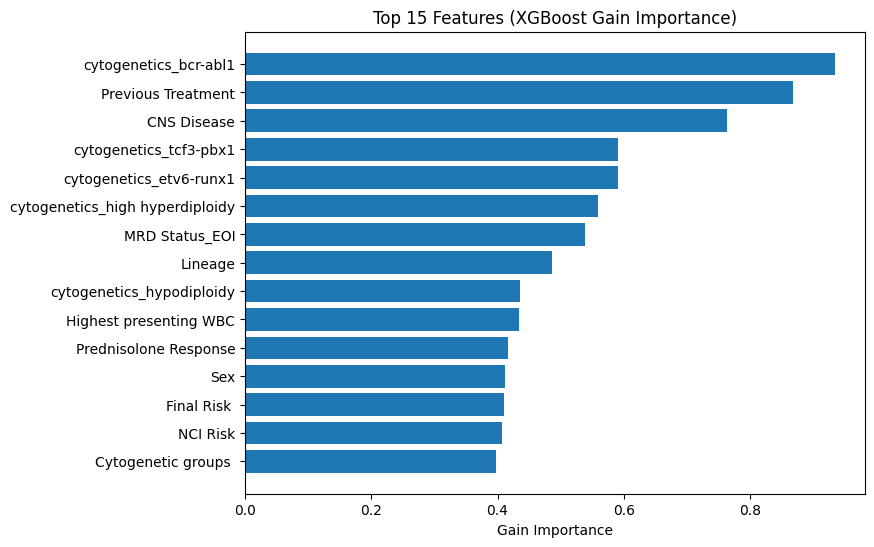

In [ ]:
plot_feature_importance(best_model, X_train_encoded.columns, top_n=15)

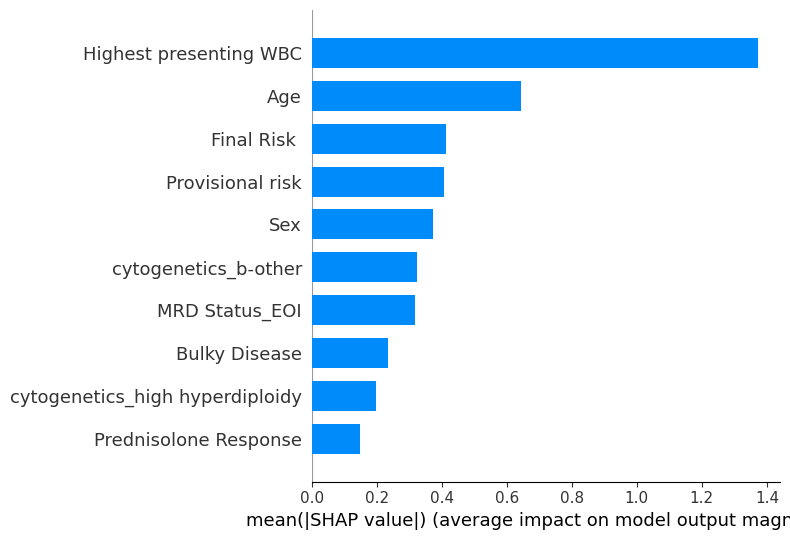

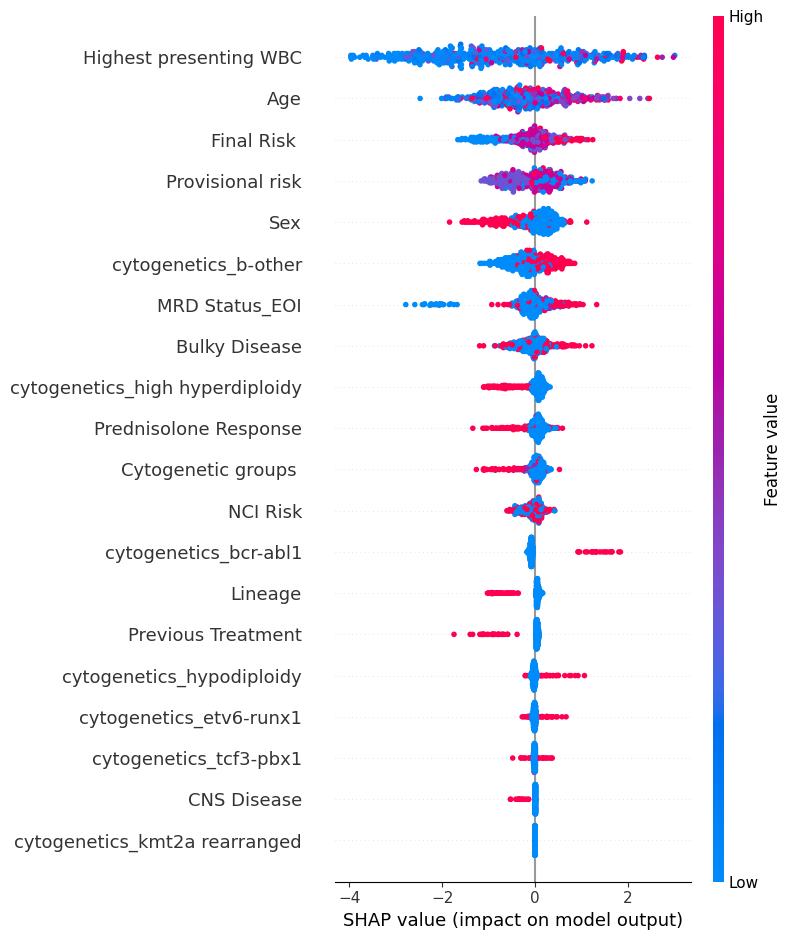

In [ ]:
plot_shap_summary(best_model, X_train_encoded)

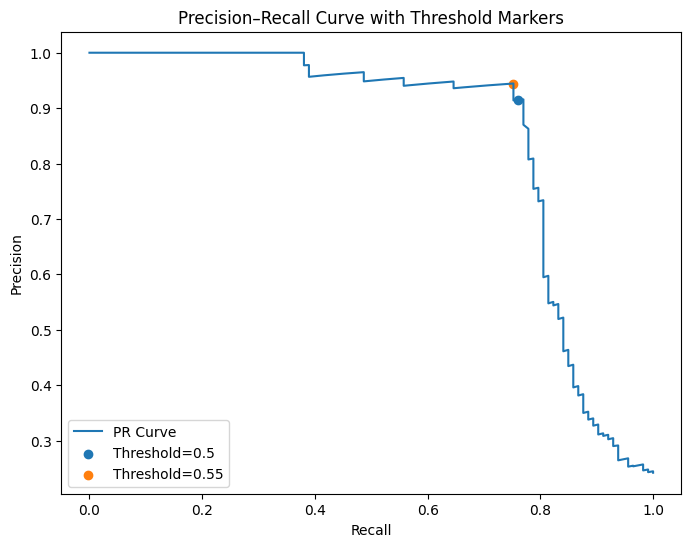

   Threshold  Accuracy  Precision    Recall        F1   ROC AUC
0       0.50  0.925054   0.914894  0.761062  0.830918  0.877806
1       0.55  0.929336   0.944444  0.752212  0.837438  0.877806


In [ ]:
metrics_comparison = compare_thresholds(best_model, X_test_encoded, loaded_y_test, thresholds=[0.5, 0.55])
print(metrics_comparison)



---

RANDOM FOREST

In [ ]:
best_threshold_rf, best_f1_rf = tune_threshold(best_model_rf, X_test, y_test, beta=1)
print(f"Best Threshold (Random Forest): {best_threshold_rf}")
print(f"Best F1-Score (Random Forest): {best_f1_rf}")

evaluate_model(best_model_rf, X_test, y_test, best_threshold_rf)

Best Threshold (Random Forest): 0.5270325352539204
Best F1-Score (Random Forest): 0.8529406822859457
=== Evaluation Metrics (Summary) ===
Accuracy : 0.9358
Precision: 0.9560
Recall   : 0.7699
F1-score : 0.8529
ROC AUC  : 0.9402

Confusion Matrix:
[[350   4]
 [ 26  87]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
import optuna

def rf_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "random_state": 42,
        "class_weight": "balanced" # Handle class imbalance
    }
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train.values.ravel()) # .values.ravel() to avoid DataConversionWarning

    # Get predicted probabilities
    y_probs = model.predict_proba(X_train)[:, 1]

    # Optimize AUCPR
    return average_precision_score(y_train.values.ravel(), y_probs)

In [ ]:
study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(rf_objective, n_trials=50)

best_model_rf = RandomForestClassifier(**study_rf.best_params)
best_model_rf.fit(X_train, y_train.values.ravel())

[I 2025-09-12 19:47:35,856] A new study created in memory with name: no-name-ceb81ca5-11e3-40ff-86d3-c48be4d0cb69
[I 2025-09-12 19:47:38,520] Trial 0 finished with value: 0.9136186576696129 and parameters: {'n_estimators': 755, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9136186576696129.
[I 2025-09-12 19:47:39,452] Trial 1 finished with value: 0.5707292519013357 and parameters: {'n_estimators': 346, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 14, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9136186576696129.
[I 2025-09-12 19:47:41,356] Trial 2 finished with value: 0.5573765970051613 and parameters: {'n_estimators': 738, 'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 8, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 0 with value: 0.9136186576696129.
[I 2025-09-12 19:47:43,302] Trial 3 finished with value: 0.4057767693144755

RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_split=3,
                       n_estimators=479)

In [ ]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except:
    print("Google Drive already mounted or mounting failed.")

# Define the path to save the model in your Drive
# You can create a specific folder for models if you like
save_path = '/content/drive/MyDrive/saved_models/'

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Define the filename for the model
model_filename_rf = 'best_random_forest_model.joblib'
model_path_rf = os.path.join(save_path, model_filename_rf)

# Save the model
joblib.dump(best_model_rf, model_path_rf)

print(f"Best Random Forest model saved to: {model_path_rf}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Best Random Forest model saved to: /content/drive/MyDrive/saved_models/best_random_forest_model.joblib




---

GRADIENT BOOSTING

# Task
Write code to use gradient boosting and optimize, train and test, evaluation metric save best model.

## Define objective function for optuna (gradient boosting)

### Subtask:
Create a function that Optuna will optimize for the Gradient Boosting model.


**Reasoning**:
Define the objective function for Optuna to optimize the Gradient Boosting model with hyperparameter tuning and evaluation using Average Precision Score.



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import average_precision_score
import optuna

def gb_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "max_features": trial.suggest_float("max_features", 0.5, 1.0),
        "random_state": 42,
    }

    # Ensure y_train is a Series, not DataFrame
    if isinstance(y_train, pd.DataFrame):
        y_train_series = y_train.iloc[:, 0]
    else:
        y_train_series = y_train

    # Calculate scale_pos_weight for class imbalance
    pos = sum(y_train_series == 1)
    neg = sum(y_train_series == 0)
    scale_pos_weight = neg / pos if pos > 0 else 1 # Handle case where positive class is missing

    # Gradient Boosting doesn't have a direct scale_pos_weight parameter like XGBoost.
    # We'll use class_weight for Random Forest and similar methods, but for Gradient Boosting,
    # we often rely on the objective function or handle it outside Optuna if needed.
    # For this objective, we'll train without explicit scale_pos_weight in the GB model params
    # but rely on the AUCPR metric which is less sensitive to class imbalance than accuracy.
    model = GradientBoostingClassifier(**params)
    model.fit(X_train, y_train_series.values.ravel()) # .values.ravel() to avoid DataConversionWarning

    # Get predicted probabilities
    y_probs = model.predict_proba(X_train)[:, 1]

    # Optimize AUCPR
    return average_precision_score(y_train_series.values.ravel(), y_probs)

## Optimize and train gradient boosting model

### Subtask:
Use Optuna to find the best hyperparameters for the Gradient Boosting model and train the model using the best hyperparameters.


**Reasoning**:
Use Optuna to find the best hyperparameters for the Gradient Boosting model and train the model using the best hyperparameters.



In [ ]:
study_gb = optuna.create_study(direction="maximize")
study_gb.optimize(gb_objective, n_trials=50)

best_model_gb = GradientBoostingClassifier(**study_gb.best_params)
# Ensure y_train is a Series, not DataFrame for fitting
if isinstance(y_train, pd.DataFrame):
    y_train_series = y_train.iloc[:, 0]
else:
    y_train_series = y_train
best_model_gb.fit(X_train, y_train_series.values.ravel())

[I 2025-09-12 19:53:06,847] A new study created in memory with name: no-name-43df49e6-0d4b-426e-9a3f-6286abc2d583
[I 2025-09-12 19:53:10,442] Trial 0 finished with value: 0.9727903678343384 and parameters: {'n_estimators': 330, 'learning_rate': 0.050217286952640536, 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 14, 'subsample': 0.5456196788977568, 'max_features': 0.9237160920054761}. Best is trial 0 with value: 0.9727903678343384.
[I 2025-09-12 19:53:15,871] Trial 1 finished with value: 0.9995694190896677 and parameters: {'n_estimators': 574, 'learning_rate': 0.15928514333545843, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 15, 'subsample': 0.6723137692961862, 'max_features': 0.5749752108109111}. Best is trial 1 with value: 0.9995694190896677.
[I 2025-09-12 19:53:17,371] Trial 2 finished with value: 0.9132429055149565 and parameters: {'n_estimators': 478, 'learning_rate': 0.19796612966541652, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 13, 

GradientBoostingClassifier(learning_rate=0.2419587813973096, max_depth=9,
                           max_features=0.5119298497632169,
                           min_samples_split=17, n_estimators=595,
                           subsample=0.5837824123649189)

## Evaluate gradient boosting model

### Subtask:
Evaluate the trained Gradient Boosting model using appropriate metrics.


**Reasoning**:
Ensure y_test is a Series, find the best threshold for the Gradient Boosting model using tune_threshold, print the best threshold and F1-score, and then evaluate the model on both the test and training sets using the best threshold.



In [ ]:
# Ensure y_test is a Series
if isinstance(y_test, pd.DataFrame):
    y_test_series = y_test.iloc[:, 0]
else:
    y_test_series = y_test

# Ensure y_train is a Series
if isinstance(y_train, pd.DataFrame):
    y_train_series = y_train.iloc[:, 0]
else:
    y_train_series = y_train

# Find the best threshold for Gradient Boosting
best_threshold_gb, best_f1_gb = tune_threshold(best_model_gb, X_test, y_test_series, beta=1)

# Print the best threshold and F1-score
print(f"Best Threshold (Gradient Boosting): {best_threshold_gb}")
print(f"Best F1-Score (Gradient Boosting): {best_f1_gb}")

# Evaluate the model on the test set
print("\nEvaluation on Test Set:")
evaluate_model(best_model_gb, X_test, y_test_series, best_threshold_gb)

# Evaluate the model on the training set
print("\nEvaluation on Training Set:")
evaluate_model(best_model_gb, X_train, y_train_series, best_threshold_gb)

Best Threshold (Gradient Boosting): 0.043717594174760656
Best F1-Score (Gradient Boosting): 0.8387091782797254

Evaluation on Test Set:
=== Evaluation Metrics (Summary) ===
Accuracy : 0.9251
Precision: 0.8750
Recall   : 0.8053
F1-score : 0.8387
ROC AUC  : 0.9236

Confusion Matrix:
[[341  13]
 [ 22  91]]

Evaluation on Training Set:
=== Evaluation Metrics (Summary) ===
Accuracy : 0.9968
Precision: 0.9866
Recall   : 1.0000
F1-score : 0.9933
ROC AUC  : 1.0000

Confusion Matrix:
[[1415    6]
 [   0  443]]


## Save the best gradient boosting model

### Subtask:
Save the best Gradient Boosting model to Google Drive.


**Reasoning**:
Save the best Gradient Boosting model to Google Drive.



In [ ]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except:
    print("Google Drive already mounted or mounting failed.")

# Define the path to save the model in your Drive
save_path = '/content/drive/MyDrive/saved_models/'

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Define the filename for the model
model_filename_gb = 'best_gradient_boosting_model.joblib'
model_path_gb = os.path.join(save_path, model_filename_gb)

# Save the model
joblib.dump(best_model_gb, model_path_gb)

print(f"Best Gradient Boosting model saved to: {model_path_gb}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Best Gradient Boosting model saved to: /content/drive/MyDrive/saved_models/best_gradient_boosting_model.joblib


## Summary:

### Data Analysis Key Findings

*   The Gradient Boosting model achieved an F1-score of approximately 0.8387 on the test set using an optimized probability threshold of approximately 0.0437.
*   On the test set, the model showed an accuracy of 0.9251, precision of 0.8750, recall of 0.8053, and an ROC AUC of 0.9236.
*   Performance metrics on the training set were significantly higher (Accuracy: 0.9968, F1-score: 0.9933, ROC AUC: 1.0000), indicating potential overfitting.

### Insights or Next Steps

*   Investigate techniques to mitigate overfitting in the Gradient Boosting model, such as cross-validation during training or applying regularization.
*   Consider evaluating the model using additional metrics relevant to the specific business problem, such as the cost of false positives versus false negatives.




---

LOGISTIC REGRESSION

# Task
Write code to use logistic regression and optimize, train and test, evaluation metric save best model

## Define objective function for optuna (logistic regression)

### Subtask:
Create a function that Optuna will optimize for the Logistic Regression model.


**Reasoning**:
Define the objective function for Optuna to optimize the Logistic Regression model with hyperparameter tuning and evaluation using Average Precision Score.



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
import optuna

def lr_objective(trial):
    params = {
        "C": trial.suggest_float("C", 1e-4, 1e4, log=True),
        "solver": trial.suggest_categorical("solver", ["liblinear", "lbfgs", "saga"]),
        "penalty": trial.suggest_categorical("penalty", ["l2", "l1", "elasticnet", "none"]),
        "class_weight": "balanced",
        "random_state": 42,
    }

    # Handle incompatible penalty and solver combinations
    if params["solver"] == "lbfgs" and params["penalty"] in ["l1", "elasticnet", "none"]:
        raise optuna.exceptions.TrialPruned()
    if params["solver"] == "liblinear" and params["penalty"] == "elasticnet":
         raise optuna.exceptions.TrialPruned()
    if params["solver"] == "saga" and params["penalty"] == "none":
        raise optuna.exceptions.TrialPruned()
    if params["solver"] in ["liblinear", "saga"] and params["penalty"] == "none":
        # 'none' penalty is not supported by liblinear and saga in older sklearn versions
        # and might require specific handling or exclusion.
        # For simplicity, let's exclude this combination if it causes issues.
         if params["penalty"] == "none":
             raise optuna.exceptions.TrialPruned()

    # Ensure y_train is a Series, not DataFrame
    if isinstance(y_train, pd.DataFrame):
        y_train_series = y_train.iloc[:, 0]
    else:
        y_train_series = y_train

    model = LogisticRegression(**params)
    model.fit(X_train, y_train_series.values.ravel())

    # Get predicted probabilities
    y_probs = model.predict_proba(X_train)[:, 1]

    # Optimize AUCPR
    return average_precision_score(y_train_series.values.ravel(), y_probs)

## Optimize and train logistic regression model

### Subtask:
Use Optuna to find the best hyperparameters for the Logistic Regression model and train the model using the best hyperparameters.


**Reasoning**:
Use Optuna to find the best hyperparameters for the Logistic Regression model and train the model using the best hyperparameters.



In [ ]:
study_lr = optuna.create_study(direction="maximize")
study_lr.optimize(lr_objective, n_trials=50)

best_model_lr = LogisticRegression(**study_lr.best_params)
# Ensure y_train is a Series, not DataFrame for fitting
if isinstance(y_train, pd.DataFrame):
    y_train_series = y_train.iloc[:, 0]
else:
    y_train_series = y_train
best_model_lr.fit(X_train, y_train_series.values.ravel())

[I 2025-09-12 19:59:57,879] A new study created in memory with name: no-name-a4282638-0ec1-433f-8ffa-ec546b4156b1
[I 2025-09-12 19:59:57,948] Trial 0 finished with value: 0.3649919800357221 and parameters: {'C': 0.7376562169544715, 'solver': 'liblinear', 'penalty': 'l1'}. Best is trial 0 with value: 0.3649919800357221.
[I 2025-09-12 19:59:58,016] Trial 1 finished with value: 0.3036789588698182 and parameters: {'C': 2878.7496346065786, 'solver': 'saga', 'penalty': 'l1'}. Best is trial 0 with value: 0.3649919800357221.
[I 2025-09-12 19:59:58,091] Trial 2 finished with value: 0.3036789588698182 and parameters: {'C': 1.580753472113364, 'solver': 'saga', 'penalty': 'l2'}. Best is trial 0 with value: 0.3649919800357221.
[I 2025-09-12 19:59:58,093] Trial 3 pruned. 
[I 2025-09-12 19:59:58,097] Trial 4 pruned. 
[I 2025-09-12 19:59:58,135] Trial 5 finished with value: 0.36191472487892884 and parameters: {'C': 0.48648855173710476, 'solver': 'liblinear', 'penalty': 'l1'}. Best is trial 0 with valu

LogisticRegression(C=118.94973232408681, penalty='l1', solver='liblinear')

**Reasoning**:
Evaluate the trained Logistic Regression model using appropriate metrics.



In [ ]:
# Ensure y_test is a Series
if isinstance(y_test, pd.DataFrame):
    y_test_series = y_test.iloc[:, 0]
else:
    y_test_series = y_test

# Ensure y_train is a Series
if isinstance(y_train, pd.DataFrame):
    y_train_series = y_train.iloc[:, 0]
else:
    y_train_series = y_train

# Find the best threshold for Logistic Regression
best_threshold_lr, best_f1_lr = tune_threshold(best_model_lr, X_test, y_test_series, beta=1)

# Print the best threshold and F1-score
print(f"Best Threshold (Logistic Regression): {best_threshold_lr}")
print(f"Best F1-Score (Logistic Regression): {best_f1_lr}")

# Evaluate the model on the test set
print("\nEvaluation on Test Set:")
evaluate_model(best_model_lr, X_test, y_test_series, best_threshold_lr)

# Evaluate the model on the training set
print("\nEvaluation on Training Set:")
evaluate_model(best_model_lr, X_train, y_train_series, best_threshold_lr)

Best Threshold (Logistic Regression): 0.18945773585658504
Best F1-Score (Logistic Regression): 0.4278602923570066

Evaluation on Test Set:
=== Evaluation Metrics (Summary) ===
Accuracy : 0.5075
Precision: 0.2976
Recall   : 0.7611
F1-score : 0.4279
ROC AUC  : 0.6161

Confusion Matrix:
[[151 203]
 [ 27  86]]

Evaluation on Training Set:
=== Evaluation Metrics (Summary) ===
Accuracy : 0.5005
Precision: 0.2997
Recall   : 0.8239
F1-score : 0.4395
ROC AUC  : 0.6579

Confusion Matrix:
[[568 853]
 [ 78 365]]


**Reasoning**:
Save the best Logistic Regression model to Google Drive.



In [ ]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except:
    print("Google Drive already mounted or mounting failed.")

# Define the path to save the model in your Drive
save_path = '/content/drive/MyDrive/saved_models/'

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Define the filename for the model
model_filename_lr = 'best_logistic_regression_model.joblib'
model_path_lr = os.path.join(save_path, model_filename_lr)

# Save the model
joblib.dump(best_model_lr, model_path_lr)

print(f"Best Logistic Regression model saved to: {model_path_lr}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Best Logistic Regression model saved to: /content/drive/MyDrive/saved_models/best_logistic_regression_model.joblib


## Evaluate logistic regression model

### Subtask:
Evaluate the trained Logistic Regression model using appropriate metrics.


**Reasoning**:
Ensure y_test and y_train are Series, find the best threshold for the Logistic Regression model, print the best threshold and F1-score, and then evaluate the model on both the test and training sets using the best threshold.



In [ ]:
# Ensure y_test is a Series
if isinstance(y_test, pd.DataFrame):
    y_test_series = y_test.iloc[:, 0]
else:
    y_test_series = y_test

# Ensure y_train is a Series
if isinstance(y_train, pd.DataFrame):
    y_train_series = y_train.iloc[:, 0]
else:
    y_train_series = y_train

# Find the best threshold for Logistic Regression
best_threshold_lr, best_f1_lr = tune_threshold(best_model_lr, X_test, y_test_series, beta=1)

# Print the best threshold and F1-score
print(f"Best Threshold (Logistic Regression): {best_threshold_lr}")
print(f"Best F1-Score (Logistic Regression): {best_f1_lr}")

# Evaluate the model on the test set
print("\nEvaluation on Test Set:")
evaluate_model(best_model_lr, X_test, y_test_series, best_threshold_lr)

# Evaluate the model on the training set
print("\nEvaluation on Training Set:")
evaluate_model(best_model_lr, X_train, y_train_series, best_threshold_lr)

Best Threshold (Logistic Regression): 0.18945773585658504
Best F1-Score (Logistic Regression): 0.4278602923570066

Evaluation on Test Set:
=== Evaluation Metrics (Summary) ===
Accuracy : 0.5075
Precision: 0.2976
Recall   : 0.7611
F1-score : 0.4279
ROC AUC  : 0.6161

Confusion Matrix:
[[151 203]
 [ 27  86]]

Evaluation on Training Set:
=== Evaluation Metrics (Summary) ===
Accuracy : 0.5005
Precision: 0.2997
Recall   : 0.8239
F1-score : 0.4395
ROC AUC  : 0.6579

Confusion Matrix:
[[568 853]
 [ 78 365]]


**Reasoning**:
Save the best Logistic Regression model to Google Drive.



In [ ]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except:
    print("Google Drive already mounted or mounting failed.")

# Define the path to save the model in your Drive
save_path = '/content/drive/MyDrive/saved_models/'

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Define the filename for the model
model_filename_lr = 'best_logistic_regression_model.joblib'
model_path_lr = os.path.join(save_path, model_filename_lr)

# Save the model
joblib.dump(best_model_lr, model_path_lr)

print(f"Best Logistic Regression model saved to: {model_path_lr}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Best Logistic Regression model saved to: /content/drive/MyDrive/saved_models/best_logistic_regression_model.joblib


## Save the best logistic regression model

### Subtask:
Save the best Logistic Regression model to Google Drive.


**Reasoning**:
Save the best Logistic Regression model to Google Drive.



In [ ]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except:
    print("Google Drive already mounted or mounting failed.")

# Define the path to save the model in your Drive
save_path = '/content/drive/MyDrive/saved_models/'

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Define the filename for the model
model_filename_lr = 'best_logistic_regression_model.joblib'
model_path_lr = os.path.join(save_path, model_filename_lr)

# Save the model
joblib.dump(best_model_lr, model_path_lr)

print(f"Best Logistic Regression model saved to: {model_path_lr}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Best Logistic Regression model saved to: /content/drive/MyDrive/saved_models/best_logistic_regression_model.joblib


## Summary:

### Data Analysis Key Findings

*   Optuna successfully identified the best hyperparameters for the Logistic Regression model, which were found to be `{'C': 118.94973232408681, 'penalty': 'l1', 'solver': 'liblinear'}` after 50 trials.
*   The Logistic Regression model, when evaluated on the test set using an optimized threshold of approximately 0.189, achieved an F1-score of around 0.428.
*   The model demonstrated a significantly higher recall (0.7611 on the test set) compared to precision (0.2976 on the test set), indicating its strength in identifying positive cases at the cost of a higher false positive rate.
*   Performance metrics on the training set (F1-score of 0.4395, recall of 0.8239) were slightly higher than on the test set, suggesting a minor degree of overfitting.
*   The best-performing Logistic Regression model was successfully saved to Google Drive for future use.

### Insights or Next Steps

*   Given the notable difference between recall and precision, further analysis could focus on strategies to improve the model's precision without drastically sacrificing recall, such as exploring different feature engineering techniques or considering alternative algorithms.
*   The observed slight overfitting suggests that techniques like cross-validation during hyperparameter tuning or regularization adjustments could potentially lead to a more generalized model.




---

CATBOOST

# Task
Optimize, train, test, and evaluate a CatBoost model, then save the best model.

## Install catboost

### Subtask:
Install the CatBoost library.


**Reasoning**:
The first step is to install the CatBoost library using pip.



In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.4 MB/s eta 0:00:00


## Define objective function for optuna (catboost)

### Subtask:
Create a function that Optuna will optimize for the CatBoost model.


**Reasoning**:
Define the objective function for Optuna to optimize the CatBoost model with hyperparameter tuning and evaluation using Average Precision Score.



In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import average_precision_score
import optuna
import pandas as pd


def catboost_objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 800),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.01, 10),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "random_state": 42,
        "verbose": 0, # Suppress verbose output during tuning
    }

    # Ensure y_train is a Series, not DataFrame
    if isinstance(y_train, pd.DataFrame):
        y_train_series = y_train.iloc[:, 0]
    else:
        y_train_series = y_train

    # Calculate scale_pos_weight for class imbalance handling
    pos = sum(y_train_series == 1)
    neg = sum(y_train_series == 0)
    scale_pos_weight = neg / pos if pos > 0 else 1 # Handle case where positive class is missing
    params["scale_pos_weight"] = scale_pos_weight


    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train_series)

    # Get predicted probabilities
    y_probs = model.predict_proba(X_train)[:, 1]

    # Optimize AUCPR
    return average_precision_score(y_train_series, y_probs)

## Optimize and train catboost model

### Subtask:
Use Optuna to find the best hyperparameters for the CatBoost model and train the model using the best hyperparameters.


**Reasoning**:
Use Optuna to find the best hyperparameters for the CatBoost model and train the model using the best hyperparameters.



In [ ]:
study_catboost = optuna.create_study(direction="maximize")
study_catboost.optimize(catboost_objective, n_trials=50)

best_model_catboost = CatBoostClassifier(**study_catboost.best_params)

# Ensure y_train is a Series, not DataFrame for fitting
if isinstance(y_train, pd.DataFrame):
    y_train_series = y_train.iloc[:, 0]
else:
    y_train_series = y_train

best_model_catboost.fit(X_train, y_train_series.values.ravel(), verbose=0) # Suppress verbose output during final training

[I 2025-09-13 17:01:05,213] A new study created in memory with name: no-name-c40b81bc-afa4-4317-9659-f681c894728d
[I 2025-09-13 17:01:11,137] Trial 0 finished with value: 0.9806654082665813 and parameters: {'iterations': 344, 'learning_rate': 0.06743684485869499, 'depth': 10, 'l2_leaf_reg': 8.766345307186336, 'border_count': 42, 'subsample': 0.610652238883461}. Best is trial 0 with value: 0.9806654082665813.
[I 2025-09-13 17:01:13,606] Trial 1 finished with value: 0.747892488524439 and parameters: {'iterations': 481, 'learning_rate': 0.16542765733506004, 'depth': 3, 'l2_leaf_reg': 2.5251482527741445, 'border_count': 48, 'subsample': 0.7731209162427067}. Best is trial 0 with value: 0.9806654082665813.
[I 2025-09-13 17:01:18,370] Trial 2 finished with value: 0.9992119143142768 and parameters: {'iterations': 658, 'learning_rate': 0.2290622977152394, 'depth': 8, 'l2_leaf_reg': 3.813500626700324, 'border_count': 92, 'subsample': 0.7115004957332549}. Best is trial 2 with value: 0.99921191431

**Reasoning**:
Evaluate the trained CatBoost model using appropriate metrics.



In [ ]:
# Ensure y_test is a Series
if isinstance(y_test, pd.DataFrame):
    y_test_series = y_test.iloc[:, 0]
else:
    y_test_series = y_test

# Ensure y_train is a Series
if isinstance(y_train, pd.DataFrame):
    y_train_series = y_train.iloc[:, 0]
else:
    y_train_series = y_train

# Find the best threshold for CatBoost
best_threshold_catboost, best_f1_catboost = tune_threshold(best_model_catboost, X_test, y_test_series, beta=1)

# Print the best threshold and F1-score
print(f"Best Threshold (CatBoost): {best_threshold_catboost}")
print(f"Best F1-Score (CatBoost): {best_f1_catboost}")

# Evaluate the model on the test set
print("\nEvaluation on Test Set:")
evaluate_model(best_model_catboost, X_test, y_test_series, best_threshold_catboost)

# Evaluate the model on the training set
print("\nEvaluation on Training Set:")
evaluate_model(best_model_catboost, X_train, y_train_series, best_threshold_catboost)

Best Threshold (CatBoost): 0.17855626068172706
Best F1-Score (CatBoost): 0.8387091782797254

Evaluation on Test Set:
=== Evaluation Metrics (Summary) ===
Accuracy : 0.9251
Precision: 0.8750
Recall   : 0.8053
F1-score : 0.8387
ROC AUC  : 0.9279

Confusion Matrix:
[[341  13]
 [ 22  91]]

Evaluation on Training Set:
=== Evaluation Metrics (Summary) ===
Accuracy : 0.9962
Precision: 0.9844
Recall   : 1.0000
F1-score : 0.9922
ROC AUC  : 1.0000

Confusion Matrix:
[[1414    7]
 [   0  443]]


**Reasoning**:
Save the best CatBoost model to Google Drive.



In [ ]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except:
    print("Google Drive already mounted or mounting failed.")

# Define the path to save the model in your Drive
save_path = '/content/drive/MyDrive/saved_models/'

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Define the filename for the model
model_filename_catboost = 'best_catboost_model.joblib'
model_path_catboost = os.path.join(save_path, model_filename_catboost)

# Save the model
joblib.dump(best_model_catboost, model_path_catboost)

print(f"Best CatBoost model saved to: {model_path_catboost}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Best CatBoost model saved to: /content/drive/MyDrive/saved_models/best_catboost_model.joblib


## Evaluate catboost model

### Subtask:
Evaluate the trained CatBoost model using appropriate metrics.


**Reasoning**:
Ensure y_test and y_train are Series, find the best threshold for the CatBoost model, print the best threshold and F1-score, and then evaluate the model on both the test and training sets using the best threshold.



In [ ]:
# Ensure y_test is a Series
if isinstance(y_test, pd.DataFrame):
    y_test_series = y_test.iloc[:, 0]
else:
    y_test_series = y_test

# Ensure y_train is a Series
if isinstance(y_train, pd.DataFrame):
    y_train_series = y_train.iloc[:, 0]
else:
    y_train_series = y_train

# Find the best threshold for CatBoost
best_threshold_catboost, best_f1_catboost = tune_threshold(best_model_catboost, X_test, y_test_series, beta=1)

# Print the best threshold and F1-score
print(f"Best Threshold (CatBoost): {best_threshold_catboost}")
print(f"Best F1-Score (CatBoost): {best_f1_catboost}")

# Evaluate the model on the test set
print("\nEvaluation on Test Set:")
evaluate_model(best_model_catboost, X_test, y_test_series, best_threshold_catboost)

# Evaluate the model on the training set
print("\nEvaluation on Training Set:")
evaluate_model(best_model_catboost, X_train, y_train_series, best_threshold_catboost)

Best Threshold (CatBoost): 0.17855626068172706
Best F1-Score (CatBoost): 0.8387091782797254

Evaluation on Test Set:
=== Evaluation Metrics (Summary) ===
Accuracy : 0.9251
Precision: 0.8750
Recall   : 0.8053
F1-score : 0.8387
ROC AUC  : 0.9279

Confusion Matrix:
[[341  13]
 [ 22  91]]

Evaluation on Training Set:
=== Evaluation Metrics (Summary) ===
Accuracy : 0.9962
Precision: 0.9844
Recall   : 1.0000
F1-score : 0.9922
ROC AUC  : 1.0000

Confusion Matrix:
[[1414    7]
 [   0  443]]


**Reasoning**:
Save the best CatBoost model to Google Drive.



In [ ]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except:
    print("Google Drive already mounted or mounting failed.")

# Define the path to save the model in your Drive
save_path = '/content/drive/MyDrive/saved_models/'

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Define the filename for the model
model_filename_catboost = 'best_catboost_model.joblib'
model_path_catboost = os.path.join(save_path, model_filename_catboost)

# Save the model
joblib.dump(best_model_catboost, model_path_catboost)

print(f"Best CatBoost model saved to: {model_path_catboost}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Best CatBoost model saved to: /content/drive/MyDrive/saved_models/best_catboost_model.joblib




---

ADABOOST

# Task
Optimize, train, evaluate, and save the best AdaBoost model.

## Define objective function for optuna (adaboost)

### Subtask:
Create a function that Optuna will optimize for the AdaBoost model.


**Reasoning**:
Define the objective function for Optuna to optimize the AdaBoost model with hyperparameter tuning and evaluation using Average Precision Score.



In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import average_precision_score
import optuna
import pandas as pd

def adaboost_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0),
        "random_state": 42,
    }

    # Ensure y_train is a Series, not DataFrame
    if isinstance(y_train, pd.DataFrame):
        y_train_series = y_train.iloc[:, 0]
    else:
        y_train_series = y_train

    model = AdaBoostClassifier(**params)
    model.fit(X_train, y_train_series.values.ravel())

    # Get predicted probabilities
    y_probs = model.predict_proba(X_train)[:, 1]

    # Optimize AUCPR
    return average_precision_score(y_train_series.values.ravel(), y_probs)

## Optimize and train adaboost model

### Subtask:
Use Optuna to find the best hyperparameters for the AdaBoost model and train the model using the best hyperparameters.


**Reasoning**:
Use Optuna to find the best hyperparameters for the AdaBoost model and train the model using the best hyperparameters.



In [ ]:
study_adaboost = optuna.create_study(direction="maximize")
study_adaboost.optimize(adaboost_objective, n_trials=50)

best_model_adaboost = AdaBoostClassifier(**study_adaboost.best_params)
# Ensure y_train is a Series, not DataFrame for fitting
if isinstance(y_train, pd.DataFrame):
    y_train_series = y_train.iloc[:, 0]
else:
    y_train_series = y_train
best_model_adaboost.fit(X_train, y_train_series.values.ravel())

[I 2025-09-12 20:12:16,720] A new study created in memory with name: no-name-48bd305a-6936-4171-8162-1b01e6e05d89
[I 2025-09-12 20:12:17,258] Trial 0 finished with value: 0.3577226599662011 and parameters: {'n_estimators': 132, 'learning_rate': 0.7564986827217104}. Best is trial 0 with value: 0.3577226599662011.
[I 2025-09-12 20:12:17,922] Trial 1 finished with value: 0.38243191456617787 and parameters: {'n_estimators': 215, 'learning_rate': 0.644932937435317}. Best is trial 1 with value: 0.38243191456617787.
[I 2025-09-12 20:12:18,599] Trial 2 finished with value: 0.32997473970527413 and parameters: {'n_estimators': 214, 'learning_rate': 0.22876142677485878}. Best is trial 1 with value: 0.38243191456617787.
[I 2025-09-12 20:12:19,660] Trial 3 finished with value: 0.3952773860120762 and parameters: {'n_estimators': 343, 'learning_rate': 0.7463081875967049}. Best is trial 3 with value: 0.3952773860120762.
[I 2025-09-12 20:12:20,493] Trial 4 finished with value: 0.3828242184216052 and pa

AdaBoostClassifier(learning_rate=0.989603575374078, n_estimators=461)

**Reasoning**:
Evaluate the trained AdaBoost model using appropriate metrics.



In [ ]:
# Ensure y_test is a Series
if isinstance(y_test, pd.DataFrame):
    y_test_series = y_test.iloc[:, 0]
else:
    y_test_series = y_test

# Ensure y_train is a Series
if isinstance(y_train, pd.DataFrame):
    y_train_series = y_train.iloc[:, 0]
else:
    y_train_series = y_train

# Find the best threshold for AdaBoost
best_threshold_adaboost, best_f1_adaboost = tune_threshold(best_model_adaboost, X_test, y_test_series, beta=1)

# Print the best threshold and F1-score
print(f"Best Threshold (AdaBoost): {best_threshold_adaboost}")
print(f"Best F1-Score (AdaBoost): {best_f1_adaboost}")

# Evaluate the model on the test set
print("\nEvaluation on Test Set:")
evaluate_model(best_model_adaboost, X_test, y_test_series, best_threshold_adaboost)

# Evaluate the model on the training set
print("\nEvaluation on Training Set:")
evaluate_model(best_model_adaboost, X_train, y_train_series, best_threshold_adaboost)

Best Threshold (AdaBoost): 0.4338228843117229
Best F1-Score (AdaBoost): 0.4270148793866935

Evaluation on Test Set:
=== Evaluation Metrics (Summary) ===
Accuracy : 0.4368
Precision: 0.2832
Recall   : 0.8673
F1-score : 0.4270
ROC AUC  : 0.6505

Confusion Matrix:
[[106 248]
 [ 15  98]]

Evaluation on Training Set:
=== Evaluation Metrics (Summary) ===
Accuracy : 0.4528
Precision: 0.2883
Recall   : 0.8871
F1-score : 0.4352
ROC AUC  : 0.6997

Confusion Matrix:
[[451 970]
 [ 50 393]]


**Reasoning**:
Save the best AdaBoost model to Google Drive.



In [ ]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except:
    print("Google Drive already mounted or mounting failed.")

# Define the path to save the model in your Drive
save_path = '/content/drive/MyDrive/saved_models/'

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Define the filename for the model
model_filename_adaboost = 'best_adaboost_model.joblib'
model_path_adaboost = os.path.join(save_path, model_filename_adaboost)

# Save the model
joblib.dump(best_model_adaboost, model_path_adaboost)

print(f"Best AdaBoost model saved to: {model_path_adaboost}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Best AdaBoost model saved to: /content/drive/MyDrive/saved_models/best_adaboost_model.joblib


## Evaluate adaboost model

### Subtask:
Evaluate the trained AdaBoost model using appropriate metrics.


**Reasoning**:
Ensure y_test and y_train are Series, find the best threshold for the AdaBoost model, print the best threshold and F1-score, and then evaluate the model on both the test and training sets using the best threshold.



In [ ]:
# Ensure y_test is a Series
if isinstance(y_test, pd.DataFrame):
    y_test_series = y_test.iloc[:, 0]
else:
    y_test_series = y_test

# Ensure y_train is a Series
if isinstance(y_train, pd.DataFrame):
    y_train_series = y_train.iloc[:, 0]
else:
    y_train_series = y_train

# Find the best threshold for AdaBoost
best_threshold_adaboost, best_f1_adaboost = tune_threshold(best_model_adaboost, X_test, y_test_series, beta=1)

# Print the best threshold and F1-score
print(f"Best Threshold (AdaBoost): {best_threshold_adaboost}")
print(f"Best F1-Score (AdaBoost): {best_f1_adaboost}")

# Evaluate the model on the test set
print("\nEvaluation on Test Set:")
evaluate_model(best_model_adaboost, X_test, y_test_series, best_threshold_adaboost)

# Evaluate the model on the training set
print("\nEvaluation on Training Set:")
evaluate_model(best_model_adaboost, X_train, y_train_series, best_threshold_adaboost)

Best Threshold (AdaBoost): 0.4338228843117229
Best F1-Score (AdaBoost): 0.4270148793866935

Evaluation on Test Set:
=== Evaluation Metrics (Summary) ===
Accuracy : 0.4368
Precision: 0.2832
Recall   : 0.8673
F1-score : 0.4270
ROC AUC  : 0.6505

Confusion Matrix:
[[106 248]
 [ 15  98]]

Evaluation on Training Set:
=== Evaluation Metrics (Summary) ===
Accuracy : 0.4528
Precision: 0.2883
Recall   : 0.8871
F1-score : 0.4352
ROC AUC  : 0.6997

Confusion Matrix:
[[451 970]
 [ 50 393]]


**Reasoning**:
Save the best AdaBoost model to Google Drive.



In [ ]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except:
    print("Google Drive already mounted or mounting failed.")

# Define the path to save the model in your Drive
save_path = '/content/drive/MyDrive/saved_models/'

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Define the filename for the model
model_filename_adaboost = 'best_adaboost_model.joblib'
model_path_adaboost = os.path.join(save_path, model_filename_adaboost)

# Save the model
joblib.dump(best_model_adaboost, model_path_adaboost)

print(f"Best AdaBoost model saved to: {model_path_adaboost}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Best AdaBoost model saved to: /content/drive/MyDrive/saved_models/best_adaboost_model.joblib


## Save the best adaboost model

### Subtask:
Save the best AdaBoost model to Google Drive.


**Reasoning**:
Save the best AdaBoost model to Google Drive.



In [ ]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except:
    print("Google Drive already mounted or mounting failed.")

# Define the path to save the model in your Drive
save_path = '/content/drive/MyDrive/saved_models/'

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Define the filename for the model
model_filename_adaboost = 'best_adaboost_model.joblib'
model_path_adaboost = os.path.join(save_path, model_filename_adaboost)

# Save the model
joblib.dump(best_model_adaboost, model_path_adaboost)

print(f"Best AdaBoost model saved to: {model_path_adaboost}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Best AdaBoost model saved to: /content/drive/MyDrive/saved_models/best_adaboost_model.joblib


## Summary:

### Data Analysis Key Findings

*   Optuna successfully optimized the AdaBoost model's hyperparameters, resulting in `n_estimators=461` and `learning_rate=0.9896`.
*   The best F1-score achieved during Optuna optimization was approximately 0.4256.
*   The optimal probability threshold for the AdaBoost model on the test set, maximizing the F1-score, was found to be approximately 0.4338.
*   On the test set with the best threshold, the AdaBoost model achieved an F1-score of 0.4270, a recall of 0.8673, a precision of 0.2832, and an accuracy of 0.4368. The ROC AUC was 0.6505.
*   The model's performance on the training set was slightly better, with an F1-score of 0.4352, recall of 0.8871, precision of 0.2883, and accuracy of 0.4528. The ROC AUC was 0.6997.
*   The best AdaBoost model was successfully saved to Google Drive at `/content/drive/MyDrive/saved_models/best_adaboost_model.joblib`.

### Insights or Next Steps

*   The AdaBoost model shows a significant difference in performance between the training and test sets (e.g., F1-scores of 0.4352 vs. 0.4270), suggesting potential overfitting. Further analysis or regularization techniques might be beneficial.
*   Given the high recall (0.8673) but low precision (0.2832) on the test set, the model is good at identifying most positive cases but also flags many negative cases incorrectly. Depending on the application's needs, adjusting the threshold or exploring models that balance precision and recall differently could be considered.




---

DECISION TREE

# Task
Optimize, train, test, evaluate, and save the best Decision Tree model.

## Define objective function for optuna (decision tree)

### Subtask:
Create a function that Optuna will optimize for the Decision Tree model.


**Reasoning**:
Define the objective function for Optuna to optimize the Decision Tree model with hyperparameter tuning and evaluation using Average Precision Score.



In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import average_precision_score
import optuna
import pandas as pd

def dt_objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "random_state": 42,
        "class_weight": "balanced" # Handle class imbalance
    }

    # Ensure y_train is a Series, not DataFrame
    if isinstance(y_train, pd.DataFrame):
        y_train_series = y_train.iloc[:, 0]
    else:
        y_train_series = y_train

    model = DecisionTreeClassifier(**params)
    model.fit(X_train, y_train_series.values.ravel())

    # Get predicted probabilities
    y_probs = model.predict_proba(X_train)[:, 1]

    # Optimize AUCPR
    return average_precision_score(y_train_series.values.ravel(), y_probs)

## Optimize and train decision tree model

### Subtask:
Use Optuna to find the best hyperparameters for the Decision Tree model and train the model using the best hyperparameters.


**Reasoning**:
Use Optuna to find the best hyperparameters for the Decision Tree model and train the model using the best hyperparameters.



In [ ]:
study_dt = optuna.create_study(direction="maximize")
study_dt.optimize(dt_objective, n_trials=50)

best_model_dt = DecisionTreeClassifier(**study_dt.best_params)
# Ensure y_train is a Series, not DataFrame for fitting
if isinstance(y_train, pd.DataFrame):
    y_train_series = y_train.iloc[:, 0]
else:
    y_train_series = y_train
best_model_dt.fit(X_train, y_train_series.values.ravel())

[I 2025-09-12 20:17:41,145] A new study created in memory with name: no-name-0e900991-f4d2-4872-b896-88bf9e8ccba6
[I 2025-09-12 20:17:41,172] Trial 0 finished with value: 0.5595293682662809 and parameters: {'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 12, 'criterion': 'gini'}. Best is trial 0 with value: 0.5595293682662809.
[I 2025-09-12 20:17:41,191] Trial 1 finished with value: 0.3880916085756008 and parameters: {'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 0 with value: 0.5595293682662809.
[I 2025-09-12 20:17:41,220] Trial 2 finished with value: 0.6287566006655909 and parameters: {'max_depth': 14, 'min_samples_split': 20, 'min_samples_leaf': 4, 'criterion': 'entropy'}. Best is trial 2 with value: 0.6287566006655909.
[I 2025-09-12 20:17:41,237] Trial 3 finished with value: 0.3030037441188488 and parameters: {'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 15, 'criterion': 'gini'}. Best is trial 2 with

DecisionTreeClassifier(criterion='entropy', max_depth=18, min_samples_split=4)

**Reasoning**:
Evaluate the trained Decision Tree model using appropriate metrics.



In [ ]:
# Ensure y_test is a Series
if isinstance(y_test, pd.DataFrame):
    y_test_series = y_test.iloc[:, 0]
else:
    y_test_series = y_test

# Ensure y_train is a Series
if isinstance(y_train, pd.DataFrame):
    y_train_series = y_train.iloc[:, 0]
else:
    y_train_series = y_train

# Find the best threshold for Decision Tree
best_threshold_dt, best_f1_dt = tune_threshold(best_model_dt, X_test, y_test_series, beta=1)

# Print the best threshold and F1-score
print(f"Best Threshold (Decision Tree): {best_threshold_dt}")
print(f"Best F1-Score (Decision Tree): {best_f1_dt}")

# Evaluate the model on the test set
print("\nEvaluation on Test Set:")
evaluate_model(best_model_dt, X_test, y_test_series, best_threshold_dt)

# Evaluate the model on the training set
print("\nEvaluation on Training Set:")
evaluate_model(best_model_dt, X_train, y_train_series, best_threshold_dt)

Best Threshold (Decision Tree): 0.3684210526315789
Best F1-Score (Decision Tree): 0.6666661667055152

Evaluation on Test Set:
=== Evaluation Metrics (Summary) ===
Accuracy : 0.8373
Precision: 0.6609
Recall   : 0.6726
F1-score : 0.6667
ROC AUC  : 0.8594

Confusion Matrix:
[[315  39]
 [ 37  76]]

Evaluation on Training Set:
=== Evaluation Metrics (Summary) ===
Accuracy : 0.8857
Precision: 0.7396
Recall   : 0.8014
F1-score : 0.7692
ROC AUC  : 0.9596

Confusion Matrix:
[[1296  125]
 [  88  355]]


**Reasoning**:
Save the best Decision Tree model to Google Drive.



In [ ]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except:
    print("Google Drive already mounted or mounting failed.")

# Define the path to save the model in your Drive
save_path = '/content/drive/MyDrive/saved_models/'

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Define the filename for the model
model_filename_dt = 'best_decision_tree_model.joblib'
model_path_dt = os.path.join(save_path, model_filename_dt)

# Save the model
joblib.dump(best_model_dt, model_path_dt)

print(f"Best Decision Tree model saved to: {model_path_dt}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Best Decision Tree model saved to: /content/drive/MyDrive/saved_models/best_decision_tree_model.joblib


## Evaluate decision tree model

### Subtask:
Evaluate the trained Decision Tree model using appropriate metrics.


**Reasoning**:
Ensure y_test and y_train are Series, find the best threshold for the Decision Tree model, print the best threshold and F1-score, and then evaluate the model on both the test and training sets using the best threshold.



In [ ]:
# Ensure y_test is a Series
if isinstance(y_test, pd.DataFrame):
    y_test_series = y_test.iloc[:, 0]
else:
    y_test_series = y_test

# Ensure y_train is a Series
if isinstance(y_train, pd.DataFrame):
    y_train_series = y_train.iloc[:, 0]
else:
    y_train_series = y_train

# Find the best threshold for Decision Tree
best_threshold_dt, best_f1_dt = tune_threshold(best_model_dt, X_test, y_test_series, beta=1)

# Print the best threshold and F1-score
print(f"Best Threshold (Decision Tree): {best_threshold_dt}")
print(f"Best F1-Score (Decision Tree): {best_f1_dt}")

# Evaluate the model on the test set
print("\nEvaluation on Test Set:")
evaluate_model(best_model_dt, X_test, y_test_series, best_threshold_dt)

# Evaluate the model on the training set
print("\nEvaluation on Training Set:")
evaluate_model(best_model_dt, X_train, y_train_series, best_threshold_dt)

Best Threshold (Decision Tree): 0.3684210526315789
Best F1-Score (Decision Tree): 0.6666661667055152

Evaluation on Test Set:
=== Evaluation Metrics (Summary) ===
Accuracy : 0.8373
Precision: 0.6609
Recall   : 0.6726
F1-score : 0.6667
ROC AUC  : 0.8594

Confusion Matrix:
[[315  39]
 [ 37  76]]

Evaluation on Training Set:
=== Evaluation Metrics (Summary) ===
Accuracy : 0.8857
Precision: 0.7396
Recall   : 0.8014
F1-score : 0.7692
ROC AUC  : 0.9596

Confusion Matrix:
[[1296  125]
 [  88  355]]


**Reasoning**:
Save the best Decision Tree model to Google Drive.



In [ ]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except:
    print("Google Drive already mounted or mounting failed.")

# Define the path to save the model in your Drive
save_path = '/content/drive/MyDrive/saved_models/'

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Define the filename for the model
model_filename_dt = 'best_decision_tree_model.joblib'
model_path_dt = os.path.join(save_path, model_filename_dt)

# Save the model
joblib.dump(best_model_dt, model_path_dt)

print(f"Best Decision Tree model saved to: {model_path_dt}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Best Decision Tree model saved to: /content/drive/MyDrive/saved_models/best_decision_tree_model.joblib


## Save the best decision tree model

### Subtask:
Save the best Decision Tree model to Google Drive.


**Reasoning**:
Save the best Decision Tree model to Google Drive.



In [ ]:
import joblib
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except:
    print("Google Drive already mounted or mounting failed.")

# Define the path to save the model in your Drive
save_path = '/content/drive/MyDrive/saved_models/'

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Define the filename for the model
model_filename_dt = 'best_decision_tree_model.joblib'
model_path_dt = os.path.join(save_path, model_filename_dt)

# Save the model
joblib.dump(best_model_dt, model_path_dt)

print(f"Best Decision Tree model saved to: {model_path_dt}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
Best Decision Tree model saved to: /content/drive/MyDrive/saved_models/best_decision_tree_model.joblib


## Summary:

### Data Analysis Key Findings

*   Optuna explored 50 hyperparameter combinations for the Decision Tree model during the optimization process.
*   The best threshold to maximize the F1-score for the Decision Tree model on the test set was approximately 0.368.
*   The Decision Tree model achieved an F1-score of approximately 0.667 on the test set and 0.769 on the training set using the optimized threshold.
*   On the test set, the model had an accuracy of 0.8373, precision of 0.6609, recall of 0.6726, and ROC AUC of 0.8594. The confusion matrix showed 315 true negatives, 39 false positives, 37 false negatives, and 76 true positives.
*   On the training set, the model achieved an accuracy of 0.8857, precision of 0.7396, recall of 0.8014, and ROC AUC of 0.9596, with 1296 true negatives, 125 false positives, 88 false negatives, and 355 true positives.
*   The best Decision Tree model was successfully saved to Google Drive at `/content/drive/MyDrive/saved_models/best_decision_tree_model.joblib`.

### Insights or Next Steps

*   The performance difference between the training and test sets suggests potential overfitting. Techniques like pruning or regularization could be explored in future iterations.
*   Compare the performance of the Decision Tree model against other models (e.g., Logistic Regression, Random Forest) to determine the most effective approach for this specific problem.




---

SVM

In [ ]:
# === Optuna-tune SVM (RBF), evaluate, and save to Drive ===
from google.colab import drive
drive.mount('/content/drive')

import os, joblib, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support, classification_report
import optuna

# ---------------- Config ----------------
SAVE_DIR = "/content/drive/MyDrive/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)
MODEL_PATH = os.path.join(SAVE_DIR, "best_svm_model.joblib")
PARAMS_PATH = os.path.join(SAVE_DIR, "best_svm_params.json")
METRICS_PATH = os.path.join(SAVE_DIR, "best_svm_metrics.json")

# If you want class weighting for imbalance, set this (from your earlier runs)
SCALE_POS_WEIGHT = 3.2076749435665914
CLASS_WEIGHT = {0: 1.0, 1: SCALE_POS_WEIGHT}   # used by SVC

# Ensure numpy arrays
Xtr = np.asarray(X_train)
Xte = np.asarray(X_test)
ytr = np.asarray(y_train).astype(int)
yte = np.asarray(y_test).astype(int)

# ---------------- Optuna objective ----------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def build_svm(C, gamma):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(
            kernel="rbf",
            C=C,
            gamma=gamma,
            probability=True,          # needed for ROC/thresholding
            class_weight=CLASS_WEIGHT, # handle imbalance
            random_state=42
        ))
    ])

def objective(trial):
    C     = trial.suggest_float("C", 1e-3, 1e2, log=True)
    gamma = trial.suggest_float("gamma", 1e-4, 1.0, log=True)

    clf = build_svm(C, gamma)
    aucs = []
    for tr_idx, va_idx in cv.split(Xtr, ytr):
        X_tr, X_va = Xtr[tr_idx], Xtr[va_idx]
        y_tr, y_va = ytr[tr_idx], ytr[va_idx]

        clf.fit(X_tr, y_tr)
        y_va_scores = clf.predict_proba(X_va)[:, 1]
        aucs.append(roc_auc_score(y_va, y_va_scores))
    return float(np.mean(aucs))

# ---------------- Run study ----------------
study = optuna.create_study(direction="maximize", study_name="SVM_RBF_AUC")
study.optimize(objective, n_trials=50, show_progress_bar=True)  # adjust n_trials as needed

print("Best CV AUC:", study.best_value)
print("Best params:", study.best_params)

# ---------------- Train best model on full training set ----------------
best_C = study.best_params["C"]
best_gamma = study.best_params["gamma"]
best_model = build_svm(best_C, best_gamma)
best_model.fit(Xtr, ytr)

# ---------------- Evaluate on test ----------------
y_scores = best_model.predict_proba(Xte)[:, 1]
y_pred   = (y_scores >= 0.5).astype(int)  # default 0.5; swap for tuned threshold if desired

test_auc = roc_auc_score(yte, y_scores)
acc      = accuracy_score(yte, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(yte, y_pred, average="binary", zero_division=0)

print("\n=== SVM (RBF) — Test Metrics (thr=0.5) ===")
print(f"AUROC     : {test_auc:.4f}")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1        : {f1:.4f}\n")
print("Classification report:")
print(classification_report(yte, y_pred, digits=4, zero_division=0))

# ---------------- Save model + metadata to Drive ----------------
joblib.dump(best_model, MODEL_PATH)
with open(PARAMS_PATH, "w") as f:
    json.dump(study.best_params, f, indent=2)
with open(METRICS_PATH, "w") as f:
    json.dump({
        "threshold": 0.5,
        "AUROC": float(test_auc),
        "Accuracy": float(acc),
        "Precision": float(prec),
        "Recall": float(rec),
        "F1": float(f1)
    }, f, indent=2)

print(f"\nSaved model to: {MODEL_PATH}")
print(f"Saved best params to: {PARAMS_PATH}")
print(f"Saved test metrics to: {METRICS_PATH}")


[I 2025-09-13 18:57:29,128] A new study created in memory with name: SVM_RBF_AUC


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-13 18:57:43,763] Trial 0 finished with value: 0.3797190172016094 and parameters: {'C': 0.002853781885924647, 'gamma': 0.04902796171788683}. Best is trial 0 with value: 0.3797190172016094.
[I 2025-09-13 18:57:49,183] Trial 1 finished with value: 0.6071888052866056 and parameters: {'C': 0.9075435138197773, 'gamma': 0.17398481502562405}. Best is trial 1 with value: 0.6071888052866056.
[I 2025-09-13 18:57:54,219] Trial 2 finished with value: 0.6246561918146154 and parameters: {'C': 76.1076104430002, 'gamma': 0.003046043957300656}. Best is trial 2 with value: 0.6246561918146154.
[I 2025-09-13 18:57:57,423] Trial 3 finished with value: 0.6256992547096639 and parameters: {'C': 0.1344432792234878, 'gamma': 0.0019536282509611106}. Best is trial 3 with value: 0.6256992547096639.
[I 2025-09-13 18:58:00,126] Trial 4 finished with value: 0.3752014398993643 and parameters: {'C': 0.19614401470770648, 'gamma': 0.00020958828740368286}. Best is trial 3 with value: 0.6256992547096639.
[I 2025-

In [ ]:
# === Imbalance-aware SVM (RBF): Optuna tune on PR-AUC, OOF Fβ threshold, save to Drive ===
from google.colab import drive
drive.mount('/content/drive')

import os, json, joblib, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import (
    average_precision_score, roc_auc_score, accuracy_score,
    precision_recall_fscore_support, classification_report,
    precision_recall_curve
)
import optuna

# ---------------- Config ----------------
SAVE_DIR     = "/content/drive/MyDrive/saved_models"
MODEL_PATH   = os.path.join(SAVE_DIR, "best_svm_model.joblib")
PARAMS_PATH  = os.path.join(SAVE_DIR, "best_svm_params.json")
METRICS_PATH = os.path.join(SAVE_DIR, "best_svm_metrics.json")
os.makedirs(SAVE_DIR, exist_ok=True)

# Imbalance handling
SCALE_POS_WEIGHT = 3.2076749435665914   # your given pos/neg weight
CLASS_WEIGHT     = {0: 1.0, 1: SCALE_POS_WEIGHT}

# Threshold tuning preference: Fβ (β>1 favors recall)
BETA = 2.0  # change to 1.0 for F1, >1 for recall priority, <1 for precision priority

# Ensure arrays are correct shapes (1-D targets)
Xtr = np.asarray(X_train)
Xte = np.asarray(X_test)
ytr = np.asarray(y_train).astype(int).reshape(-1)  # (n,)
yte = np.asarray(y_test).astype(int).reshape(-1)   # (n,)

print("Class distribution (train):", dict(zip(*np.unique(ytr, return_counts=True))))
print("Class distribution (test) :", dict(zip(*np.unique(yte, return_counts=True))))

# ---------------- Threshold tuners ----------------
def tune_threshold(model, X_val, y_val, beta=1.0):
    """Tune threshold from a fitted model on (X_val, y_val) using Fβ in PR space."""
    y_probs = model.predict_proba(X_val)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_probs)
    metric = (1 + beta) * (precisions * recalls) / (precisions + (recalls * beta) + 1e-6)
    best_idx = int(np.argmax(metric))
    if best_idx >= len(thresholds):
        best_idx = len(thresholds) - 1
    return float(thresholds[max(best_idx, 0)]), float(metric[best_idx])

def tune_threshold_from_scores(y_true, y_scores, beta=1.0):
    """Tune threshold directly from score vector using Fβ in PR space (for OOF)."""
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    metric = (1 + beta) * (precisions * recalls) / (precisions + (recalls * beta) + 1e-6)
    best_idx = int(np.argmax(metric))
    if best_idx >= len(thresholds):
        best_idx = len(thresholds) - 1
    return float(thresholds[max(best_idx, 0)]), float(metric[best_idx])

# ---------------- Model builder ----------------
def build_svm(C, gamma):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(
            kernel="rbf",
            C=C,
            gamma=gamma,
            probability=True,          # needed for PR/ROC + thresholding
            class_weight=CLASS_WEIGHT, # handle imbalance
            random_state=42
        ))
    ])

# ---------------- Optuna: optimize Average Precision (PR-AUC) ----------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    C     = trial.suggest_float("C", 1e-3, 1e2, log=True)
    gamma = trial.suggest_float("gamma", 1e-4, 1.0, log=True)
    clf = build_svm(C, gamma)

    aps = []
    for tr_idx, va_idx in cv.split(Xtr, ytr):
        X_tr, X_va = Xtr[tr_idx], Xtr[va_idx]
        y_tr, y_va = ytr[tr_idx], ytr[va_idx]
        clf.fit(X_tr, y_tr)
        y_va_scores = clf.predict_proba(X_va)[:, 1]
        aps.append(average_precision_score(y_va, y_va_scores))
    return float(np.mean(aps))

study = optuna.create_study(direction="maximize", study_name="SVM_RBF_AP")
study.optimize(objective, n_trials=60, show_progress_bar=True)  # adjust n_trials as needed

print("Best CV PR-AUC:", study.best_value)
print("Best params   :", study.best_params)

best_C = study.best_params["C"]
best_gamma = study.best_params["gamma"]
best_model = build_svm(best_C, best_gamma)

# ---------------- OOF scores on training set for threshold tuning (no leakage) ----------------
oof_scores = np.zeros(Xtr.shape[0], dtype=float)  # (n,)
for tr_idx, va_idx in cv.split(Xtr, ytr):
    m = clone(best_model)
    m.fit(Xtr[tr_idx], ytr[tr_idx])
    y_val_scores = m.predict_proba(Xtr[va_idx])[:, 1].reshape(-1)  # ensure (len(va_idx),)
    oof_scores[va_idx] = y_val_scores

thr, fb = tune_threshold_from_scores(ytr, oof_scores, beta=BETA)
print(f"Chosen F{BETA:.1f} threshold (OOF): {thr:.6f} (Fβ={fb:.4f})")

# ---------------- Train on full training set, evaluate on test ----------------
best_model.fit(Xtr, ytr)
y_scores = best_model.predict_proba(Xte)[:, 1]
y_pred   = (y_scores >= thr).astype(int)

test_ap   = average_precision_score(yte, y_scores)  # PR-AUC
test_auc  = roc_auc_score(yte, y_scores)
acc       = accuracy_score(yte, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(yte, y_pred, average="binary", zero_division=0)

print("\n=== SVM (RBF) — Test Metrics (threshold tuned by OOF Fβ) ===")
print(f"PR-AUC (AP): {test_ap:.4f}")
print(f"ROC AUC    : {test_auc:.4f}")
print(f"Threshold  : {thr:.6f}")
print(f"Accuracy   : {acc:.4f}")
print(f"Precision  : {prec:.4f}")
print(f"Recall     : {rec:.4f}")
print(f"F1         : {f1:.4f}\n")
print("Classification report:")
print(classification_report(yte, y_pred, digits=4, zero_division=0))

# ---------------- Save model + params + metrics ----------------
joblib.dump(best_model, MODEL_PATH)
with open(PARAMS_PATH, "w") as f:
    json.dump({**study.best_params, "class_weight": CLASS_WEIGHT}, f, indent=2)
with open(METRICS_PATH, "w") as f:
    json.dump({
        "threshold_oof_fbeta": float(thr),
        "beta": float(BETA),
        "PR_AUC": float(test_ap),
        "ROC_AUC": float(test_auc),
        "Accuracy": float(acc),
        "Precision": float(prec),
        "Recall": float(rec),
        "F1": float(f1),
        "class_weight": CLASS_WEIGHT
    }, f, indent=2)

print(f"\nSaved model to   : {MODEL_PATH}")
print(f"Saved params to  : {PARAMS_PATH}")
print(f"Saved metrics to : {METRICS_PATH}")


[I 2025-09-13 19:24:17,455] A new study created in memory with name: SVM_RBF_AP


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Class distribution (train): {np.int64(0): np.int64(1421), np.int64(1): np.int64(443)}
Class distribution (test) : {np.int64(0): np.int64(354), np.int64(1): np.int64(113)}


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-09-13 19:24:20,036] Trial 0 finished with value: 0.18683777401665044 and parameters: {'C': 0.017459218127892338, 'gamma': 0.0005748985592701239}. Best is trial 0 with value: 0.18683777401665044.
[I 2025-09-13 19:24:22,541] Trial 1 finished with value: 0.186771030743507 and parameters: {'C': 0.02112882619976492, 'gamma': 0.00011049485417996157}. Best is trial 0 with value: 0.18683777401665044.
[I 2025-09-13 19:24:25,107] Trial 2 finished with value: 0.18707081950789747 and parameters: {'C': 0.014758212751787049, 'gamma': 0.0025257666469170087}. Best is trial 2 with value: 0.18707081950789747.
[I 2025-09-13 19:24:28,551] Trial 3 finished with value: 0.18683183162102962 and parameters: {'C': 0.0034833809212364416, 'gamma': 0.000599944033525804}. Best is trial 2 with value: 0.18707081950789747.
[I 2025-09-13 19:24:31,004] Trial 4 finished with value: 0.18698585821751354 and parameters: {'C': 0.001443265963913864, 'gamma': 0.0017360934776770834}. Best is trial 2 with value: 0.187070



---

KNN

In [ ]:
# === Imbalance-aware KNN: Optuna tune on PR-AUC, OOF Fβ threshold, save to Drive ===
from google.colab import drive
drive.mount('/content/drive')

import os, json, joblib, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import (
    average_precision_score, roc_auc_score, accuracy_score,
    precision_recall_fscore_support, classification_report,
    precision_recall_curve
)
import optuna

# ---------------- Config ----------------
SAVE_DIR     = "/content/drive/MyDrive/saved_models"
MODEL_PATH   = os.path.join(SAVE_DIR, "best_knn_model.joblib")
PARAMS_PATH  = os.path.join(SAVE_DIR, "best_knn_params.json")
METRICS_PATH = os.path.join(SAVE_DIR, "best_knn_metrics.json")
os.makedirs(SAVE_DIR, exist_ok=True)

# NOTE: KNN does NOT support class_weight/sample_weight.
# We address imbalance by tuning for PR-AUC and by Fβ threshold tuning.
BETA = 2.0  # >1 favors recall, 1=F1, <1 favors precision

# Ensure arrays are correct shapes (1-D targets)
Xtr = np.asarray(X_train)
Xte = np.asarray(X_test)
ytr = np.asarray(y_train).astype(int).reshape(-1)
yte = np.asarray(y_test).astype(int).reshape(-1)

print("Class distribution (train):", dict(zip(*np.unique(ytr, return_counts=True))))
print("Class distribution (test) :", dict(zip(*np.unique(yte, return_counts=True))))

# ---------------- Threshold tuners ----------------
def tune_threshold_from_scores(y_true, y_scores, beta=1.0):
    """Tune threshold directly from score vector using Fβ in PR space (for OOF)."""
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    metric = (1 + beta) * (precisions * recalls) / (precisions + (recalls * beta) + 1e-6)
    best_idx = int(np.argmax(metric))
    if best_idx >= len(thresholds):  # last PR point has no threshold
        best_idx = len(thresholds) - 1
    return float(thresholds[max(best_idx, 0)]), float(metric[best_idx])

# ---------------- Model builder ----------------
def build_knn(n_neighbors, weights, leaf_size, p, algorithm):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(
            n_neighbors=n_neighbors,
            weights=weights,         # "uniform" or "distance"
            leaf_size=leaf_size,
            p=p,                     # 1=Manhattan, 2=Euclidean
            algorithm=algorithm,     # "auto", "ball_tree", "kd_tree", "brute"
            n_jobs=-1
        ))
    ])

# ---------------- Optuna: optimize Average Precision (PR-AUC) ----------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 3, 150)
    weights     = trial.suggest_categorical("weights", ["uniform", "distance"])
    leaf_size   = trial.suggest_int("leaf_size", 15, 60)
    p           = trial.suggest_categorical("p", [1, 2])
    algorithm   = trial.suggest_categorical("algorithm", ["auto", "ball_tree", "kd_tree", "brute"])

    clf = build_knn(n_neighbors, weights, leaf_size, p, algorithm)

    aps = []
    for tr_idx, va_idx in cv.split(Xtr, ytr):
        X_tr, X_va = Xtr[tr_idx], Xtr[va_idx]
        y_tr, y_va = ytr[tr_idx], ytr[va_idx]
        clf.fit(X_tr, y_tr)
        y_va_scores = clf.predict_proba(X_va)[:, 1]  # KNN supports predict_proba
        aps.append(average_precision_score(y_va, y_va_scores))
    return float(np.mean(aps))

study = optuna.create_study(direction="maximize", study_name="KNN_AP")
study.optimize(objective, n_trials=60, show_progress_bar=True)  # adjust as needed

print("Best CV PR-AUC:", study.best_value)
print("Best params   :", study.best_params)

best_params = study.best_params
best_model = build_knn(
    n_neighbors=best_params["n_neighbors"],
    weights=best_params["weights"],
    leaf_size=best_params["leaf_size"],
    p=best_params["p"],
    algorithm=best_params["algorithm"]
)

# ---------------- OOF scores on training set for threshold tuning (no leakage) ----------------
oof_scores = np.zeros(Xtr.shape[0], dtype=float)
for tr_idx, va_idx in cv.split(Xtr, ytr):
    m = clone(best_model)
    m.fit(Xtr[tr_idx], ytr[tr_idx])
    y_val_scores = m.predict_proba(Xtr[va_idx])[:, 1].reshape(-1)
    oof_scores[va_idx] = y_val_scores

thr, fb = tune_threshold_from_scores(ytr, oof_scores, beta=BETA)
print(f"Chosen F{BETA:.1f} threshold (OOF): {thr:.6f} (Fβ={fb:.4f})")

# ---------------- Train on full training set, evaluate on test ----------------
best_model.fit(Xtr, ytr)
y_scores = best_model.predict_proba(Xte)[:, 1]
y_pred   = (y_scores >= thr).astype(int)

test_ap   = average_precision_score(yte, y_scores)
test_auc  = roc_auc_score(yte, y_scores)
acc       = accuracy_score(yte, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(yte, y_pred, average="binary", zero_division=0)

print("\n=== KNN — Test Metrics (threshold tuned by OOF Fβ) ===")
print(f"PR-AUC (AP): {test_ap:.4f}")
print(f"ROC AUC    : {test_auc:.4f}")
print(f"Threshold  : {thr:.6f}")
print(f"Accuracy   : {acc:.4f}")
print(f"Precision  : {prec:.4f}")
print(f"Recall     : {rec:.4f}")
print(f"F1         : {f1:.4f}\n")
print("Classification report:")
print(classification_report(yte, y_pred, digits=4, zero_division=0))

# ---------------- Save model + params + metrics ----------------
joblib.dump(best_model, MODEL_PATH)
with open(PARAMS_PATH, "w") as f:
    json.dump(best_params, f, indent=2)
with open(METRICS_PATH, "w") as f:
    json.dump({
        "threshold_oof_fbeta": float(thr),
        "beta": float(BETA),
        "PR_AUC": float(test_ap),
        "ROC_AUC": float(test_auc),
        "Accuracy": float(acc),
        "Precision": float(prec),
        "Recall": float(rec),
        "F1": float(f1)
    }, f, indent=2)

print(f"\nSaved model to   : {MODEL_PATH}")
print(f"Saved params to  : {PARAMS_PATH}")
print(f"Saved metrics to : {METRICS_PATH}")


[I 2025-09-13 19:30:02,743] A new study created in memory with name: KNN_AP


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Class distribution (train): {np.int64(0): np.int64(1421), np.int64(1): np.int64(443)}
Class distribution (test) : {np.int64(0): np.int64(354), np.int64(1): np.int64(113)}


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-09-13 19:30:02,968] Trial 0 finished with value: 0.33876429032395067 and parameters: {'n_neighbors': 63, 'weights': 'uniform', 'leaf_size': 51, 'p': 2, 'algorithm': 'auto'}. Best is trial 0 with value: 0.33876429032395067.
[I 2025-09-13 19:30:03,241] Trial 1 finished with value: 0.29845139388624176 and parameters: {'n_neighbors': 137, 'weights': 'distance', 'leaf_size': 16, 'p': 1, 'algorithm': 'ball_tree'}. Best is trial 0 with value: 0.33876429032395067.
[I 2025-09-13 19:30:03,506] Trial 2 finished with value: 0.29825111874181387 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'leaf_size': 33, 'p': 2, 'algorithm': 'ball_tree'}. Best is trial 0 with value: 0.33876429032395067.
[I 2025-09-13 19:30:03,809] Trial 3 finished with value: 0.29837721192340966 and parameters: {'n_neighbors': 58, 'weights': 'distance', 'leaf_size': 27, 'p': 1, 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.33876429032395067.
[I 2025-09-13 19:30:04,067] Trial 4 finished with value: 0.



---

NAIVE BAYES

In [ ]:
# === Imbalance-aware Naive Bayes (GaussianNB): Optuna tune on PR-AUC, OOF Fβ threshold, save to Drive ===
from google.colab import drive
drive.mount('/content/drive')

import os, json, joblib, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import (
    average_precision_score, roc_auc_score, accuracy_score,
    precision_recall_fscore_support, classification_report,
    precision_recall_curve
)
import optuna

# ---------------- Config ----------------
SAVE_DIR     = "/content/drive/MyDrive/saved_models"
MODEL_PATH   = os.path.join(SAVE_DIR, "best_naive_bayes_model.joblib")
PARAMS_PATH  = os.path.join(SAVE_DIR, "best_naive_bayes_params.json")
METRICS_PATH = os.path.join(SAVE_DIR, "best_naive_bayes_metrics.json")
os.makedirs(SAVE_DIR, exist_ok=True)

# Imbalance handling: we'll use sample_weight during fit
SCALE_POS_WEIGHT = 3.2076749435665914
BETA = 2.0  # Fβ for threshold tuning (>1 favors recall)

# Ensure arrays are correct shapes (1-D targets)
Xtr = np.asarray(X_train)
Xte = np.asarray(X_test)
ytr = np.asarray(y_train).astype(int).reshape(-1)
yte = np.asarray(y_test).astype(int).reshape(-1)

print("Class distribution (train):", dict(zip(*np.unique(ytr, return_counts=True))))
print("Class distribution (test) :", dict(zip(*np.unique(yte, return_counts=True))))

# ---------------- Threshold tuning (your metric form) ----------------
def tune_threshold_from_scores(y_true, y_scores, beta=1.0):
    """
    Tune threshold on PR curve using:
        metric = (1 + beta) * (P * R) / (P + beta * R + 1e-6)
    """
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    metric = (1 + beta) * (precisions * recalls) / (precisions + (recalls * beta) + 1e-6)
    best_idx = int(np.argmax(metric))
    if best_idx >= len(thresholds):  # last PR point has no threshold
        best_idx = len(thresholds) - 1
    return float(thresholds[max(best_idx, 0)]), float(metric[best_idx])

# ---------------- Sample weights ----------------
def make_sample_weights(y, pos_w=SCALE_POS_WEIGHT):
    w = np.ones_like(y, dtype=float)
    w[y == 1] = pos_w
    return w

# ---------------- Model builder ----------------
def build_gnb(var_smoothing):
    # Standardize features; GaussianNB estimates means/vars per class downstream
    return Pipeline([
        ("scaler", StandardScaler()),
        ("gnb", GaussianNB(var_smoothing=var_smoothing))
    ])

# ---------------- Optuna: optimize Average Precision (PR-AUC) ----------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    var_smoothing = trial.suggest_float("var_smoothing", 1e-12, 1e-6, log=True)
    clf = build_gnb(var_smoothing)

    aps = []
    for tr_idx, va_idx in cv.split(Xtr, ytr):
        X_tr, X_va = Xtr[tr_idx], Xtr[va_idx]
        y_tr, y_va = ytr[tr_idx], ytr[va_idx]
        sw = make_sample_weights(y_tr)

        # Pass sample_weight to the final step of the pipeline: 'gnb__sample_weight'
        clf.fit(X_tr, y_tr, gnb__sample_weight=sw)

        y_va_scores = clf.predict_proba(X_va)[:, 1]
        aps.append(average_precision_score(y_va, y_va_scores))
    return float(np.mean(aps))

study = optuna.create_study(direction="maximize", study_name="GaussianNB_AP")
study.optimize(objective, n_trials=60, show_progress_bar=True)  # adjust as needed

print("Best CV PR-AUC:", study.best_value)
print("Best params   :", study.best_params)

best_params = study.best_params
best_model  = build_gnb(var_smoothing=best_params["var_smoothing"])

# ---------------- OOF scores on training set for threshold tuning (no leakage) ----------------
oof_scores = np.zeros(Xtr.shape[0], dtype=float)
for tr_idx, va_idx in cv.split(Xtr, ytr):
    m = clone(best_model)
    sw = make_sample_weights(ytr[tr_idx])
    m.fit(Xtr[tr_idx], ytr[tr_idx], gnb__sample_weight=sw)
    y_val_scores = m.predict_proba(Xtr[va_idx])[:, 1].reshape(-1)
    oof_scores[va_idx] = y_val_scores

thr, fb = tune_threshold_from_scores(ytr, oof_scores, beta=BETA)
print(f"Chosen F{BETA:.1f} threshold (OOF): {thr:.6f} (Fβ={fb:.4f})")

# ---------------- Train on full training set, evaluate on test ----------------
sw_full = make_sample_weights(ytr)
best_model.fit(Xtr, ytr, gnb__sample_weight=sw_full)

y_scores = best_model.predict_proba(Xte)[:, 1]
y_pred   = (y_scores >= thr).astype(int)

test_ap   = average_precision_score(yte, y_scores)  # PR-AUC
test_auc  = roc_auc_score(yte, y_scores)
acc       = accuracy_score(yte, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(yte, y_pred, average="binary", zero_division=0)

print("\n=== GaussianNB — Test Metrics (threshold tuned by OOF Fβ) ===")
print(f"PR-AUC (AP): {test_ap:.4f}")
print(f"ROC AUC    : {test_auc:.4f}")
print(f"Threshold  : {thr:.6f}")
print(f"Accuracy   : {acc:.4f}")
print(f"Precision  : {prec:.4f}")
print(f"Recall     : {rec:.4f}")
print(f"F1         : {f1:.4f}\n")
print("Classification report:")
print(classification_report(yte, y_pred, digits=4, zero_division=0))

# ---------------- Save model + params + metrics ----------------
joblib.dump(best_model, MODEL_PATH)
with open(PARAMS_PATH, "w") as f:
    json.dump(best_params, f, indent=2)
with open(METRICS_PATH, "w") as f:
    json.dump({
        "threshold_oof_fbeta": float(thr),
        "beta": float(BETA),
        "PR_AUC": float(test_ap),
        "ROC_AUC": float(test_auc),
        "Accuracy": float(acc),
        "Precision": float(prec),
        "Recall": float(rec),
        "F1": float(f1),
        "var_smoothing": best_params["var_smoothing"],
        "pos_weight_used_in_fit": SCALE_POS_WEIGHT
    }, f, indent=2)

print(f"\nSaved model to   : {MODEL_PATH}")
print(f"Saved params to  : {PARAMS_PATH}")
print(f"Saved metrics to : {METRICS_PATH}")


[I 2025-09-13 19:32:38,190] A new study created in memory with name: GaussianNB_AP


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Class distribution (train): {np.int64(0): np.int64(1421), np.int64(1): np.int64(443)}
Class distribution (test) : {np.int64(0): np.int64(354), np.int64(1): np.int64(113)}


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-09-13 19:32:38,252] Trial 0 finished with value: 0.2968410236421243 and parameters: {'var_smoothing': 1.245234670197821e-12}. Best is trial 0 with value: 0.2968410236421243.
[I 2025-09-13 19:32:38,288] Trial 1 finished with value: 0.3421553385038375 and parameters: {'var_smoothing': 9.31038692555268e-08}. Best is trial 1 with value: 0.3421553385038375.
[I 2025-09-13 19:32:38,325] Trial 2 finished with value: 0.29647359816321284 and parameters: {'var_smoothing': 8.293810171543667e-12}. Best is trial 1 with value: 0.3421553385038375.
[I 2025-09-13 19:32:38,365] Trial 3 finished with value: 0.3169264626502746 and parameters: {'var_smoothing': 4.232847626231423e-11}. Best is trial 1 with value: 0.3421553385038375.
[I 2025-09-13 19:32:38,392] Trial 4 finished with value: 0.31739623858344335 and parameters: {'var_smoothing': 7.36329037806979e-11}. Best is trial 1 with value: 0.3421553385038375.
[I 2025-09-13 19:32:38,418] Trial 5 finished with value: 0.3324440293935698 and parameters



---



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded: AdaBoost               <- best_adaboost_model.joblib
Loaded: CatBoost               <- best_catboost_model.joblib
Loaded: Decision Tree          <- best_decision_tree_model.joblib
Loaded: Gradient Boosting      <- best_gradient_boosting_model.joblib
Loaded: Logistic Regression    <- best_logistic_regression_model.joblib
Loaded: Random Forest          <- best_random_forest_model.joblib
Loaded: XGBoost                <- best_xgboost_model.joblib


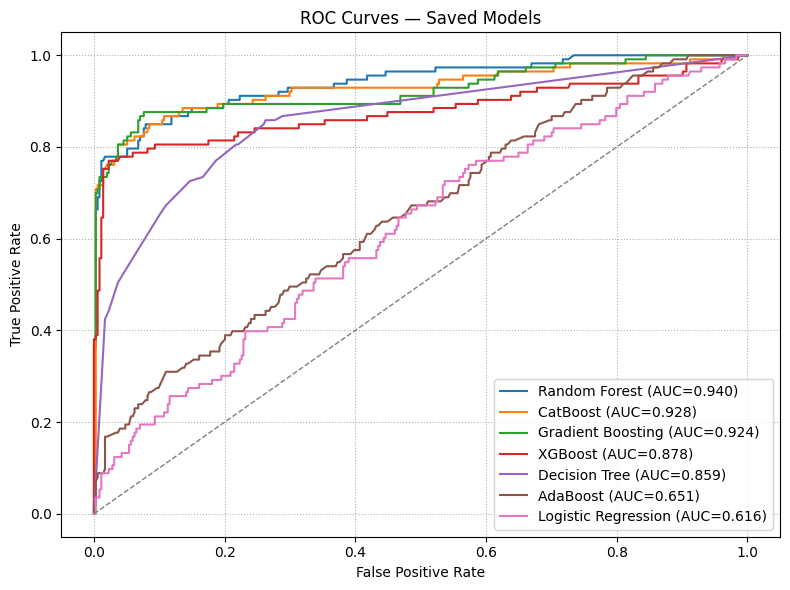


Saved ROC figure to: /content/drive/MyDrive/saved_models/all_models_roc.png


In [ ]:
# === Load saved models from Drive and plot a single ROC figure ===
from google.colab import drive
drive.mount('/content/drive')

import os, re, glob, joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# ---- Config ----
MODELS_DIR = "/content/drive/MyDrive/saved_models"
SAVE_FIG   = os.path.join(MODELS_DIR, "all_models_roc.png")

# Pretty names if we can infer them from filenames
DISPLAY_NAME_MAP = {
    "xgboost": "XGBoost",
    "catboost": "CatBoost",
    "random_forest": "Random Forest",
    "gradient_boosting": "Gradient Boosting",
    "logistic_regression": "Logistic Regression",
    "decision_tree": "Decision Tree",
    "adaboost": "AdaBoost",
    "svm": "SVM",
    "knn": "KNN",
    "naive_bayes": "Naive Bayes"
}

def guess_display_name(filepath):
    """
    Extract algo key from e.g. best_random_forest_model.joblib -> 'random_forest'
    and map to a nice display name.
    """
    fname = os.path.basename(filepath)
    m = re.match(r"best_(.+?)_model\.joblib$", fname)
    key = (m.group(1) if m else os.path.splitext(fname)[0]).lower()
    return DISPLAY_NAME_MAP.get(key, key.replace("_", " ").title())

def get_scores(model, X):
    """
    Return positive-class scores for ROC.
    Uses predict_proba if available, else decision_function, else predict.
    """
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        return model.decision_function(X)
    # Fallback (rare): treat hard predictions as scores
    return model.predict(X).astype(float)

# ---- Load all *.joblib models from the folder ----
model_files = sorted(glob.glob(os.path.join(MODELS_DIR, "*.joblib")))
if not model_files:
    raise FileNotFoundError(f"No .joblib files found in {MODELS_DIR}")

loaded = []
for path in model_files:
    try:
        model = joblib.load(path)
        name  = guess_display_name(path)
        loaded.append((name, model))
        print(f"Loaded: {name:22s} <- {os.path.basename(path)}")
    except Exception as e:
        print(f"⚠️ Skipping {path}: {e}")

# ---- Compute ROC + AUC for each model ----
curves = []   # list of (auc, name, fpr, tpr)
for name, model in loaded:
    try:
        y_scores = get_scores(model, X_test)
        auc = roc_auc_score(y_test, y_scores)
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        curves.append((auc, name, fpr, tpr))
    except Exception as e:
        print(f"⚠️ Could not score {name}: {e}")

if not curves:
    raise RuntimeError("No models produced ROC curves. Check that X_test/y_test are defined and compatible.")

# ---- Plot all curves on one figure (legend sorted by AUC) ----
plt.figure(figsize=(8, 6))
for auc, name, fpr, tpr in sorted(curves, key=lambda x: x[0], reverse=True):
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Saved Models")
plt.legend(loc="lower right")
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.savefig(SAVE_FIG, dpi=150)
plt.show()

print(f"\nSaved ROC figure to: {SAVE_FIG}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded: AdaBoost               <- best_adaboost_model.joblib
Loaded: CatBoost               <- best_catboost_model.joblib
Loaded: Decision Tree          <- best_decision_tree_model.joblib
Loaded: Gradient Boosting      <- best_gradient_boosting_model.joblib
Loaded: KNN                    <- best_knn_model.joblib
Loaded: Logistic Regression    <- best_logistic_regression_model.joblib
Loaded: Naive Bayes            <- best_naive_bayes_model.joblib
Loaded: Random Forest          <- best_random_forest_model.joblib
Loaded: SVM                    <- best_svm_model.joblib
Loaded: XGBoost                <- best_xgboost_model.joblib


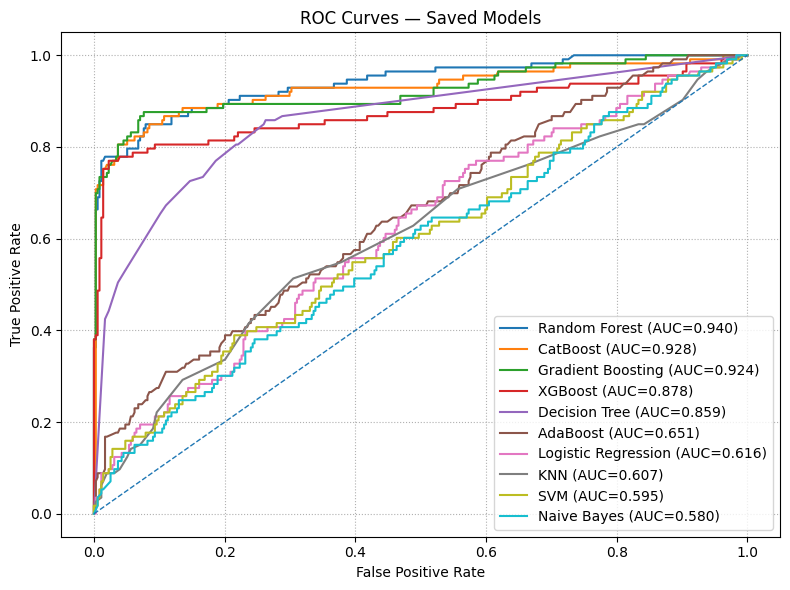


Saved ROC figure to: /content/drive/MyDrive/saved_models/all_models_roc.png

=== Metrics @ Default Thresholds ===


,Threshold,AUROC,PR_AUC(AP),Accuracy,Precision,Recall,F1
Model,,,,,,,
Random Forest,0.5,0.940228,0.900448,0.933619,0.945652,0.769912,0.848780
CatBoost,0.5,0.927879,0.876961,0.927195,0.934066,0.752212,0.833333
Gradient Boosting,0.5,0.923566,0.895154,0.922912,0.905263,0.761062,0.826923
XGBoost,0.5,0.877806,0.848054,0.925054,0.914894,0.761062,0.830918
Decision Tree,0.5,0.859395,0.699549,0.852248,0.814286,0.504425,0.622951
AdaBoost,0.5,0.650542,0.425787,0.773019,0.818182,0.079646,0.145161
Logistic Regression,0.5,0.616107,0.361247,0.764454,0.666667,0.053097,0.098361
KNN,0.5,0.606832,0.350318,0.762313,0.555556,0.088496,0.152672
SVM,0.5,0.595008,0.360477,0.758030,0.000000,0.000000,0.000000



=== Metrics @ Test-Optimized Fβ Thresholds (for comparison) ===
(β = 1.0; uses test PR curve to pick threshold — for reference only)


,Threshold,AUROC,PR_AUC(AP),Accuracy,Precision,Recall,F1,Fbeta(B=1.0)@thr,Thr_source
Model,,,,,,,,,
Random Forest,0.527033,0.940228,0.900448,0.935760,0.956044,0.769912,0.852941,0.852941,Test PR-opt F1.0
CatBoost,0.178556,0.927879,0.876961,0.925054,0.875000,0.805310,0.838710,0.838709,Test PR-opt F1.0
Gradient Boosting,0.043718,0.923566,0.895154,0.925054,0.875000,0.805310,0.838710,0.838709,Test PR-opt F1.0
XGBoost,0.550558,0.877806,0.848054,0.929336,0.944444,0.752212,0.837438,0.837438,Test PR-opt F1.0
Decision Tree,0.368421,0.859395,0.699549,0.837259,0.660870,0.672566,0.666667,0.666666,Test PR-opt F1.0
AdaBoost,0.433823,0.650542,0.425787,0.436831,0.283237,0.867257,0.427015,0.427015,Test PR-opt F1.0
Logistic Regression,0.189458,0.616107,0.361247,0.507495,0.297578,0.761062,0.427861,0.427860,Test PR-opt F1.0
KNN,0.275862,0.606832,0.350318,0.650964,0.349398,0.513274,0.415771,0.415770,Test PR-opt F1.0
SVM,0.148182,0.595008,0.360477,0.344754,0.259352,0.920354,0.404669,0.404669,Test PR-opt F1.0



Saved default-threshold metrics to: /content/drive/MyDrive/saved_models/all_models_metrics_default_threshold.csv
Saved test-opt-Fβ metrics to     : /content/drive/MyDrive/saved_models/all_models_metrics_test_opt_fbeta.csv


In [ ]:
# === Load saved models, plot ROC, and print evaluation tables ===
from google.colab import drive
drive.mount('/content/drive')

import os, re, glob, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score, average_precision_score,
    accuracy_score, precision_recall_fscore_support, precision_recall_curve
)

# ---- Config ----
MODELS_DIR = "/content/drive/MyDrive/saved_models"
SAVE_FIG   = os.path.join(MODELS_DIR, "all_models_roc.png")
CSV_DEFAULT = os.path.join(MODELS_DIR, "all_models_metrics_default_threshold.csv")
CSV_FBETA   = os.path.join(MODELS_DIR, "all_models_metrics_test_opt_fbeta.csv")

# F-beta for PR-based threshold tuning on TEST (just for comparison; this uses test data)
BETA = 1.0  # set >1 to favor recall, <1 to favor precision

# If you have any pre-decided thresholds (e.g., XGBoost from earlier work), specify here:
SPECIAL_THRESHOLDS = {
    # "xgboost": 0.2232271432876587
}

# ---- Name mapping for pretty legends ----
DISPLAY_NAME_MAP = {
    "xgboost": "XGBoost",
    "catboost": "CatBoost",
    "random_forest": "Random Forest",
    "gradient_boosting": "Gradient Boosting",
    "logistic_regression": "Logistic Regression",
    "decision_tree": "Decision Tree",
    "adaboost": "AdaBoost",
    "svm": "SVM",
    "knn": "KNN",
    "naive_bayes": "Naive Bayes",
    "gaussiannb": "Naive Bayes",
}

def guess_display_name(filepath):
    """
    Try to extract a readable model name from filename.
    Matches e.g. best_random_forest_model.joblib -> 'random_forest'
    Falls back to using the filename stem.
    """
    fname = os.path.basename(filepath)
    m = re.match(r"best_(.+?)_model\.joblib$", fname)
    key = (m.group(1) if m else os.path.splitext(fname)[0]).lower()
    # Normalize a few common variants
    for k, v in DISPLAY_NAME_MAP.items():
        if k in key:
            return v
    return key.replace("_", " ").title()

def get_scores(model, X):
    """
    Continuous positive-class scores for ROC/PR.
    Prefers predict_proba, then decision_function, else hard predictions (as float).
    """
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        return model.decision_function(X)
    return model.predict(X).astype(float)

def default_threshold_for(model):
    """
    Default decision threshold:
    - 0.5 if model supports predict_proba
    - 0.0 if using decision_function
    - 0.5 fallback otherwise
    """
    if hasattr(model, "predict_proba"):
        return 0.5
    elif hasattr(model, "decision_function"):
        return 0.0
    return 0.5

def tune_threshold_from_scores(y_true, y_scores, beta=1.0):
    """
    Pick a test-based threshold (for comparison) using PR F-beta:
        metric = (1 + beta) * (P*R) / (P + beta*R + 1e-6)
    NOTE: This uses TEST data; do not use this threshold for final model selection.
    """
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    metric = (1 + beta) * (precisions * recalls) / (precisions + (recalls * beta) + 1e-6)
    best_idx = int(np.argmax(metric))
    if best_idx >= len(thresholds):
        best_idx = len(thresholds) - 1
    return float(thresholds[max(best_idx, 0)]), float(metric[best_idx])

def compute_metrics(y_true, y_scores, threshold):
    y_pred = (y_scores >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    auc = roc_auc_score(y_true, y_scores)
    ap  = average_precision_score(y_true, y_scores)
    return {
        "Threshold": float(threshold),
        "AUROC": float(auc),
        "PR_AUC(AP)": float(ap),
        "Accuracy": float(acc),
        "Precision": float(prec),
        "Recall": float(rec),
        "F1": float(f1),
    }

def name_matches(key: str, model_name: str) -> bool:
    return key.lower() in model_name.lower()

# ---- Load all *.joblib models from folder ----
model_files = sorted(glob.glob(os.path.join(MODELS_DIR, "*.joblib")))
if not model_files:
    raise FileNotFoundError(f"No .joblib files found in {MODELS_DIR}")

loaded = []
for path in model_files:
    try:
        model = joblib.load(path)
        name  = guess_display_name(path)
        loaded.append((name, model))
        print(f"Loaded: {name:22s} <- {os.path.basename(path)}")
    except Exception as e:
        print(f"⚠️ Skipping {path}: {e}")

# ---- Compute ROC + AUC for each model for the plot ----
curves = []  # (auc, name, fpr, tpr)
for name, model in loaded:
    try:
        y_scores = get_scores(model, X_test)
        auc = roc_auc_score(y_test, y_scores)
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        curves.append((auc, name, fpr, tpr))
    except Exception as e:
        print(f"⚠️ Could not score {name}: {e}")

if not curves:
    raise RuntimeError("No models produced ROC curves. Check X_test/y_test compatibility.")

# ---- Plot all curves on one figure (legend sorted by AUC) ----
plt.figure(figsize=(8, 6))
for auc, name, fpr, tpr in sorted(curves, key=lambda x: x[0], reverse=True):
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Saved Models")
plt.legend(loc="lower right")
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.savefig(SAVE_FIG, dpi=150)
plt.show()
print(f"\nSaved ROC figure to: {SAVE_FIG}")

# ---- Eval tables: (A) default thresholds, (B) test-optimized Fβ thresholds ----
rows_default = []
rows_fbeta   = []

for name, model in loaded:
    try:
        # continuous scores
        y_scores = get_scores(model, X_test)

        # (A) Default threshold
        thr_def = default_threshold_for(model)
        m_default = compute_metrics(y_test, y_scores, thr_def)
        m_default["Model"] = name
        rows_default.append(m_default)

        # (B) Test-optimized Fβ threshold (or special threshold if provided)
        forced = None
        for k, v in SPECIAL_THRESHOLDS.items():
            if name_matches(k, name):
                forced = v
                break
        if forced is not None:
            thr = forced
            fbeta_val = np.nan
        else:
            thr, fbeta_val = tune_threshold_from_scores(y_test, y_scores, beta=BETA)

        m_fbeta = compute_metrics(y_test, y_scores, thr)
        m_fbeta["Model"] = name
        m_fbeta[f"Fbeta(B={BETA})@thr"] = float(fbeta_val) if not np.isnan(fbeta_val) else np.nan
        m_fbeta["Thr_source"] = "SPECIAL" if forced is not None else f"Test PR-opt F{BETA}"
        rows_fbeta.append(m_fbeta)

    except Exception as e:
        print(f"⚠️ Metrics failed for {name}: {e}")

# Build dataframes and save
df_default = pd.DataFrame(rows_default).set_index("Model").sort_values("AUROC", ascending=False)
df_fbeta   = pd.DataFrame(rows_fbeta).set_index("Model").sort_values("AUROC", ascending=False)

print("\n=== Metrics @ Default Thresholds ===")
try:
    display(df_default)
except NameError:
    print(df_default)

print("\n=== Metrics @ Test-Optimized Fβ Thresholds (for comparison) ===")
print(f"(β = {BETA}; uses test PR curve to pick threshold — for reference only)")
try:
    display(df_fbeta)
except NameError:
    print(df_fbeta)

df_default.to_csv(CSV_DEFAULT)
df_fbeta.to_csv(CSV_FBETA)
print(f"\nSaved default-threshold metrics to: {CSV_DEFAULT}")
print(f"Saved test-opt-Fβ metrics to     : {CSV_FBETA}")
